In [94]:
# Suzan Iloglu, Dec 11,2020
# Positive results from Pfizer, Moderna and AstraZeneca show a vaccine can work
# In this research, we wanna show the allocation of vaccine over the us by states and then by counties
# Import packages
import csv

from itertools import product
import geopandas as gpd
import pandas as pd
import numpy as np
import math
import time
import requests
import io
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
pd.options.display.max_columns =200
from IPython.display import Image
import sodapy
from sodapy import Socrata


# MAPPING THE VACCINE ALLOCATION
The project presents multiple options for how to distribute vaccine within each county per state. It shows that what you choose to prioritize greatly impacts where care would be sent. 
The followings are our options to choose to define vulnerability:


- SOCIAL VULNERABILITY INDEX
- MEDICAID 
- UNEMPLOYMENT
- YEARS OF POTENTIAL LIFE LOST
- TOTAL COVID CASES
- COVID CASES BY POPULATION
- COVID DEATHS BY POPULATION

We will start with Social Vulnerability Index (SVI) from CDC website.

### I. Importing SVI data which includes the variables for calculating county SVI for each state
The CDC uses both a USA-wide and a state by state SVI scores. For our project given that funding is likely going to be managed at a state level, using a state by state SVI scores makes the most sense and will be most sensitive to regional socioeconomic differences. Even though the CDC SVI scores are calculated using percentile rankings, the data sets include raw data estimates for each variables. The following table shows the variablaes used in the method of calculating SVI scores. 




      American Community Survey (ACS), 2015-2019 (5-year) data for the following estimates:
<img src="Data/img/SVI_comp.png" width="500">


Note: Full documentation for 2018 data is available <a href="https://svi.cdc.gov/data-and-tools-download.html">here</a> 
This part of the code shows preliminary mapping of <a href = "https://svi.cdc.gov/">the CDC's Social Vulnerability Index</a>.

Later in the notebook, we will provide the formula to create the SVI value we use in our project. First, we import the data for the US mainland and Puerto Rico.

In [95]:
## import svi data downloaded from CDC website as cited above

## 48 state SVI scores by county
#svi_counties_mainland = gpd.read_file("Data/SVI2018_US_COUNTY/SVI2018_US_county.shp")

## Puerto Rico SVI scores by county
#svi_counties_puerto_rico = gpd.read_file("Data/PuertoRico_COUNTY/SVI2018_PuertoRico_county.shp")

## Merge 48 states and Puerto Rico SVI 
#svi_counties = pd.concat([svi_counties_mainland,svi_counties_puerto_rico ], sort = False)
svi_counties =  pd.read_csv('Input/SVI_2019_State_Data.csv')
svi_counties.head(5)

,FIPS,COUNTY,STATE,E_NOHSDP,E_AGE17,E_POV,E_PCI,E_GROUPQ,E_AGE65,EP_AGE65,E_TOTPOP,EP_NOHSDP,EP_POV,E_UNINSUR,EP_UNINSUR,E_HH,E_DISABL,EP_DISABL,E_UNEMP,EP_UNEMP,E_HU,E_MOBILE,EP_MOBILE,E_NOVEH,EP_NOVEH,M_NOHSDP,M_AGE17,M_POV,M_PCI,M_GROUPQ,M_AGE65,MP_AGE65,M_TOTPOP,MP_NOHSDP,MP_POV,M_UNINSUR,MP_UNINSUR,M_HH,M_DISABL,MP_DISABL,M_UNEMP,MP_UNEMP,M_HU,M_MOBILE,MP_MOBILE,M_NOVEH,MP_NOVEH,ST,EP_PCI,MP_PCI,E_SNGPNT,M_SNGPNT,E_MINRTY,M_MINRTY,E_LIMENG,M_LIMENG,E_MUNIT,M_MUNIT,E_CROWD,M_CROWD,EP_AGE17,MP_AGE17,EP_SNGPNT,MP_SNGPNT,EP_MINRTY,MP_MINRTY,EP_LIMENG,MP_LIMENG,EP_MUNIT,MP_MUNIT,EP_CROWD,MP_CROWD,EP_GROUPQ,MP_GROUPQ,EPL_POV,EPL_UNEMP,EPL_PCI,EPL_NOHSDP,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,SPL_THEME2,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,SPL_THEME3_xMin,RPL_THEME3_xMin,SPL_THEMES_xMin,RPL_THEMES_xMin,RPL_rank,RPL_xMin_rank
0,1063,Greene County,Alabama,1204,1884,3140,14884,68,1773,21.3,8324,20.8,38.1,1057,12.8,2951,2039,24.7,311,11.5,5112,1828,35.8,531,18.0,241,13.0,537,1570,32.0,NaN,NaN,NaN,4.2,6.5,260,3.1,246,318,3.8,137,5.1,29,206,4.0,177,5.8,1,14884,1570,333,107.154095,6889,NaN,4,66.452991,299,153.287312,64,51.244512,22.633349,NaN,11.284310,3.507149,82.760692,NaN,0.051640,0.857901,5.848983,2.998395,2.168756,1.727077,0.816915,NaN,0.994906,0.954955,0.972662,0.888889,3.811412,0.985673,0.751476,0.554919,0.960840,0.987902,3.255137,0.993314,0.986310,0.076421,1.062731,0.542502,0.751476,0.975148,0.584654,0.985399,0.110793,3.407469,0.920089,11.536749,0.994269,0.076421,0.076421,10.550439,0.992677,67.0,67.0
1,1005,Barbour County,Alabama,4812,5307,6875,18473,2886,4710,18.6,25361,26.8,30.7,2544,11.3,9345,4806,21.4,849,9.2,12013,3520,29.3,950,10.2,333,27.0,558,942,339.0,38.0,0.1,NaN,1.8,2.4,342,1.5,313,369,1.6,176,1.9,143,255,2.0,184,2.0,1,18473,942,444,105.801701,13743,NaN,454,170.569634,208,86.023253,360,157.175062,20.925831,NaN,4.751204,1.120935,54.189504,NaN,1.890721,0.710349,1.731458,0.715788,3.852327,1.676960,11.379677,NaN,0.976441,0.913327,0.939733,0.972939,3.802439,0.984400,0.505747,0.328558,0.882840,0.274117,1.991261,0.475326,0.896530,0.736564,1.633094,0.876472,0.335508,0.930724,0.863312,0.894377,0.947787,3.971708,0.995861,11.398502,0.992359,0.736564,0.736564,10.501972,0.991722,66.0,66.0
2,1107,Pickens County,Alabama,2680,4031,4204,23024,1829,3739,18.5,20243,18.5,22.7,1697,9.1,7637,4657,25.1,802,10.3,9588,2414,25.2,787,10.3,273,NaN,561,1440,264.0,23.0,0.1,NaN,1.9,3.0,326,1.7,279,383,2.1,204,2.5,116,254,2.7,170,2.1,1,23024,1440,535,113.877127,9383,NaN,322,132.582050,158,69.462220,100,63.126856,19.913056,NaN,7.005369,1.468997,46.351825,NaN,1.678307,0.691034,1.647893,0.724196,1.309415,0.825207,9.035222,NaN,0.885387,0.940043,0.773221,0.814072,3.412724,0.922954,0.496738,0.225406,0.966253,0.829672,2.518069,0.786692,0.857052,0.709848,1.566900,0.846864,0.320596,0.886300,0.277726,0.896552,0.918179,3.299353,0.886979,10.797046,0.974530,0.709848,0.709848,9.939994,0.973575,64.0,65.0
3,1131,Wilcox County,Alabama,1675,2577,3111,16841,251,2026,19.0,10681,23.5,30.1,1134,10.9,3854,2001,19.2,541,15.3,5777,2333,40.4,600,15.6,204,NaN,417,1299,108.0,NaN,NaN,NaN,2.9,4.1,221,2.1,213,272,2.6,152,3.8,44,196,3.4,131,3.1,1,16841,1299,218,75.802375,7814,NaN,65,115.585466,8,23.021729,54,55.713553,24.126954,NaN,5.656461,1.941846,73.157944,NaN,0.649351,NaN,0.138480,0.398505,1.401142,1.443528,2.349967,NaN,0.972620,0.979807,0.958993,0.939191,3.850612,0.990767,0.548618,0.758994,0.779370,0.553327,2.640308,0.841452,0.972620,0.453557,1.426177,0.767590,0.036347,0.990991,0.316869,0.974837,0.579752,2.898795,0.701687,10.815893,0.975486,0.453557,0.453557,9.843272,0.967845,65.0,64.0
4,1105,Perry County,Alabama,1010,2007,2612,15055,810,1772,19.1,9293,17.2,30.8,846,9.3,3070,2016,22.1,290,10.1,4736,1153,24.3,399,13.0,277,NaN,669,2347,200.0,NaN,NaN,NaN,4.7,7.8,283,3.1,314,337,3.7,184,6.2,75,251,5.3,180,5.6,1,15055,2347,225,113.225439,6566,

In [96]:
## Create the list for State
S = svi_counties.STATE.unique().tolist()
if "0" in S:
    S.remove(0)
State = [str(s).strip() for s in S]
State

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'District of Columbia',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming',
 'Puerto Rico']

In [97]:
## Replacing -999 values with 0 for calculations
svi_county = svi_counties.fillna(0)
svi_county  = svi_county.replace(-999, 0)
svi_county['FIPS'] = svi_county['FIPS'].astype(int)
svi_county.shape

(3220, 105)

In [98]:
# Create a seperate dictionary for the variables to calculate SVI

# Persons below poverty estimate, 2014-2018 ACS
E_POV = dict(zip(svi_county.FIPS, svi_county.E_POV))

# Civilian (age 16+) unemployed estimate, 2014-2018 ACS
E_UNEMP = dict(zip(svi_county.FIPS, svi_county.E_UNEMP))

# Per capita income estimate, 2014-2018 ACS
E_PCI = dict(zip(svi_county.FIPS, svi_county.E_PCI))

# Persons (age 25+) with no high school diploma estimate, 2014-2018 ACS
E_NOHSDP = dict(zip(svi_county.FIPS, svi_county.E_NOHSDP))

# Persons aged 65 and older estimate
E_AGE65 = dict(zip(svi_county.FIPS, svi_county.E_AGE65))

# Persons aged 17 and younger estimate
E_AGE17 = dict(zip(svi_county.FIPS, svi_county.E_AGE17))

# Population with a disability estimate
E_DISABL = dict(zip(svi_county.FIPS, svi_county.E_DISABL))

# Single parent households with children under 18 estimate
E_SNGPNT = dict(zip(svi_county.FIPS, svi_county.E_SNGPNT))

# Minority (all persons except white, nonHispanic) estimate, 2014-2018 ACS
E_MINRTY = dict(zip(svi_county.FIPS, svi_county.E_MINRTY))

# Persons (age 5+) who speak English "less than well" estimate, 2014-2018 ACS
E_LIMENG = dict(zip(svi_county.FIPS, svi_county.E_LIMENG))

# Housing in structures with 10 or more units estimate, 2014-2018 ACS
E_MUNIT = dict(zip(svi_county.FIPS, svi_county.E_MUNIT))

# Mobile homes estimate MOE, 2014-2018 ACS
E_MOBILE = dict(zip(svi_county.FIPS, svi_county.E_MOBILE))

# At household level (occupied housing units), more people than rooms estimate, 2014-2018 ACS
E_CROWD = dict(zip(svi_county.FIPS, svi_county.E_CROWD))

# Households with no vehicle available estimate, 2014-2018 ACS
E_NOVEH = dict(zip(svi_county.FIPS, svi_county.E_NOVEH))

# Persons in institutionalized group quarters estimate, 2014-2018 ACS
E_GROUPQ = dict(zip(svi_county.FIPS, svi_county.E_GROUPQ))

# Percentage of persons below poverty estimate
E_POV = dict(zip(svi_county.FIPS, svi_county.E_POV))

In [99]:
df_mmm = pd.read_csv("Input/ACSST5Y2019.S2704_data_with_overlays_2020-12-11T225641.csv", header=[1])
df_mmm.head(1)
#df_mmm.dtypes

,id,Geographic Area Name,Estimate!!Total!!Civilian noninstitutionalized population,Margin of Error!!Total!!Civilian noninstitutionalized population,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination!!Under 19,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination!!Under 19,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination!!19 to 64 years,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination!!19 to 64 years,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination!!65 years and over,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination!!65 years and over,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination!!Under 19,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination!!Under 19,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination!!19 to 64 years,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination!!19 to 64 years,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination!!65 years and over,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination!!65 years and over,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination!!Under 19,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination!!Under 19,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination!!19 to 64 years,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination!!19 to 64 years,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination!!65 years and over,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination!!65 years and over,Estimate!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Below 138 percent of the poverty threshold,Margin of Error!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Below 138 percent of the poverty threshold,Estimate!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!At or above 138 percent of the poverty threshold,Margin of Error!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!At or above 138 percent of the poverty threshold,"Estimate!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Worked full-time, year-round (19-64 years)","Margin of Error!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Worked full-time, year-round (19-64 years)",Estimate!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Under 6,Margin of Error!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Under 6,Estimate!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!6 to 18 years,Margin of Error!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!6 to 18 years,Estimate!!Total!!PUBLIC HEALTH INSURANCE ALON

In [100]:

pandemic_i = pd.read_csv("https://raw.githubusercontent.com/COVID19PVI/data/master/Model11.2.1/Model_11.2.1_20201215_results.csv")

#pandemic_index[['Name','NAME']] = pandemic_index['Name'].str.split(',',expand=True)
pandemic_i.head(5)

,ToxPi Score,HClust Group,KMeans Group,Name,Source,Infection Rate: Transmissible Cases!25!0xcc3333ff,Infection Rate: Disease Spread!5!0xe64d4dff,Pop Concentration: Pop Mobility!10!0x57b757ff,Pop Concentration: Residential Density!10!0x5ced5cff,Intervention: Social Distancing!10!0x4258c9ff,Intervention: Testing!10!0x6079f7ff,Health & Environment: Pop Demographics!10!0x6b0b9eff,Health & Environment: Air Pollution!10!0x8e26c4ff,Health & Environment: Age Distribution!10!0x9a42c8ff,Health & Environment: Co-morbidities!10!0xb460e0ff,Health & Environment: Health Disparities!10!0xc885ecff,Health & Environment: Hospital Beds!5!0xdeb9f1ff
0,0.638253,6,4,"Mississippi, Neshoba","-89.1173,32.7534",0.673873,0.164261,0.540407,0.8316,0.750,0.766526,0.907980,0.443114,0.521532,0.607214,0.612941,0.460080
1,0.635230,7,7,"Alabama, Talladega","-86.1689,33.3782",0.645233,0.220816,0.578332,0.7985,1.000,0.867080,0.597357,0.508982,0.560557,0.560892,0.541342,0.407683
2,0.634814,7,7,"Virginia, Galax City","-80.917,36.666",0.731868,0.200097,0.703484,0.9188,1.000,0.746181,0.441340,0.335329,0.666136,0.473758,0.628630,0.183602
3,0.634474,7,7,"Kansas, Wyandotte","-94.7638,39.1173",0.681493,0.186529,0.713249,0.6686,1.000,0.938396,0.674713,0.425150,0.419125,0.474933,0.657392,0.324750
4,0.628516,6,4,"Mississippi, Leake","-89.524,32.7537",0.657959,0.182865,0.451002,0.9220,0.675,0.766526,0.881904,0.425150,0.511724,0.536734,0.673518,0.553126


In [101]:
pandemic_input = pd.read_csv("https://raw.githubusercontent.com/COVID19PVI/data/master/Model11.2.1/Model_11.2.1_20201216_data.csv", header = [12])


pandemic_input.head(5)


,row,sid,casrn,name,Spread,Sick,PctCases,Cases,CountyCaseRate,StateCaseRate,PctDeaths,Deaths,PctDeaths2,CountyDeathRate,StateDeathRate,StatePctTested,StateTestRate,SVISocioeconomic,SVIMinority,SVIHousing,PctBeds,Mobility,PctNoIns,PctGE65,DaytimePopDensity,PrematureDeath,Smoking,AirPollution,Diabetes,Traffic,DistancingGrade,Obesity,PctBlack,PctNative
0,1,"-86.6441,32.5395",1001,"Alabama, Autauga",0.177466,10.935055,0.061618,3426,1.014996,1.012372,0.012551,43,0.000773,1.006827,1.006616,0.354384,1.005746,0.3631,0.5947,0.3741,0.001529,1733.08,7.1,14.6,76.0,8128.591190,0.180816,11.7,0.111,88.457040,5.0,0.333,0.193432,0.004802
1,2,"-87.7221,30.7277",1003,"Alabama, Baldwin",0.181720,9.219253,0.050733,11061,1.014887,1.012372,0.012747,141,0.000647,1.000000,1.006616,0.354384,1.005746,0.2232,0.4358,0.3359,0.001523,1971.57,10.2,19.5,121.0,7354.122530,0.174890,10.3,0.107,86.997430,5.0,0.310,0.087840,0.007724
2,3,"-85.3871,31.8683",1005,"Alabama, Barbour",0.079721,4.139705,0.051927,1292,1.005886,1.012372,0.023220,30,0.001206,1.000000,1.006616,0.354384,1.005746,0.9780,0.8558,0.9889,0.002974,1080.54,11.2,18.0,27.5,10253.573403,0.220000,11.5,0.176,102.291762,3.7,0.417,0.480326,0.006591
3,4,"-87.1251,32.9964",1007,"Alabama, Bibb",0.199468,13.392857,0.067143,1504,1.019148,1.012372,0.025931,39,0.001741,1.000000,1.006616,0.354384,1.005746,0.7694,0.4323,0.7189,0.001563,1272.47,7.9,16.3,28.9,11977.539484,0.191142,11.2,0.145,29.335580,4.0,0.376,0.211205,0.004375
4,5,"-86.5679,33.9821",1009,"Alabama, Blount",0.211286,14.177040,0.067099,3881,1.017974,1.012372,0.012626,49,0.000847,1.009066,1.006616,0.354384,1.005746,0.6143,0.5915,0.1741,0.000692,1395.46,11.0,17.8,71.7,11335.071134,0.192087,11.7,0.170,33.411782,4.3,0.338,0.014627,0.006535


In [102]:
pandemic_in = pd.merge(left = pandemic_i, right = pandemic_input[['sid', 'casrn']], how = 'left', left_on = 'Source', right_on = 'sid')

pandemic_in.head(5)



,ToxPi Score,HClust Group,KMeans Group,Name,Source,Infection Rate: Transmissible Cases!25!0xcc3333ff,Infection Rate: Disease Spread!5!0xe64d4dff,Pop Concentration: Pop Mobility!10!0x57b757ff,Pop Concentration: Residential Density!10!0x5ced5cff,Intervention: Social Distancing!10!0x4258c9ff,Intervention: Testing!10!0x6079f7ff,Health & Environment: Pop Demographics!10!0x6b0b9eff,Health & Environment: Air Pollution!10!0x8e26c4ff,Health & Environment: Age Distribution!10!0x9a42c8ff,Health & Environment: Co-morbidities!10!0xb460e0ff,Health & Environment: Health Disparities!10!0xc885ecff,Health & Environment: Hospital Beds!5!0xdeb9f1ff,sid,casrn
0,0.638253,6,4,"Mississippi, Neshoba","-89.1173,32.7534",0.673873,0.164261,0.540407,0.8316,0.750,0.766526,0.907980,0.443114,0.521532,0.607214,0.612941,0.460080,"-89.1173,32.7534",28099
1,0.635230,7,7,"Alabama, Talladega","-86.1689,33.3782",0.645233,0.220816,0.578332,0.7985,1.000,0.867080,0.597357,0.508982,0.560557,0.560892,0.541342,0.407683,"-86.1689,33.3782",1121
2,0.634814,7,7,"Virginia, Galax City","-80.917,36.666",0.731868,0.200097,0.703484,0.9188,1.000,0.746181,0.441340,0.335329,0.666136,0.473758,0.628630,0.183602,"-80.917,36.666",51640
3,0.634474,7,7,"Kansas, Wyandotte","-94.7638,39.1173",0.681493,0.186529,0.713249,0.6686,1.000,0.938396,0.674713,0.425150,0.419125,0.474933,0.657392,0.324750,"-94.7638,39.1173",20209
4,0.628516,6,4,"Mississippi, Leake","-89.524,32.7537",0.657959,0.182865,0.451002,0.9220,0.675,0.766526,0.881904,0.425150,0.511724,0.536734,0.673518,0.553126,"-89.524,32.7537",28079


In [103]:
PVI_county = dict(zip(pandemic_in.casrn, pandemic_in['ToxPi Score']))


In [104]:
ADI =  pd.read_csv('Input/ADI_2019.csv')
ADI.head(5)

,GEOID,NAME,STATE,ADI_US,ADI_ST,ADI_US_Scaled,ADI_ST_Scaled,st,ADI_US_rank,ADI_ST_rank
0,1001,Autauga County,Alabama,90.180531,68.898514,40.14,4.86,1,5,5.0
1,1003,Baldwin County,Alabama,83.132327,55.593936,36.20,4.70,1,2,2.0
2,1005,Barbour County,Alabama,133.749446,129.732504,64.48,5.58,1,64,64.0
3,1007,Bibb County,Alabama,111.576263,100.930506,52.09,5.24,1,33,33.0
4,1009,Blount County,Alabama,101.762939,87.270465,46.61,5.08,1,13,14.0


In [105]:
df_mmm['FIPS'] = df_mmm.id.astype(str).str[9:]
df_mmm.head(5)
df_mmm.FIPS.astype(int)
df_mmm['FIPS'] = pd.to_numeric(df_mmm['FIPS'])

In [106]:
#2019 ADI data
ADI_county  = dict(zip(df_mmm['FIPS'], df_mmm["Estimate!!Public Coverage!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination"]))

df_a = pd.read_csv("Input/ACSST5Y2019.S0101_data_with_overlays_2020-12-15T094007.csv", header=[1])
df_a.head(1)


# 2018
# ADI_total  = dict(zip(df_mmm['FIPS'], df_mmm["Estimate!!Public Coverage!!Medicaid/means-tested public coverage alone or in combination"]))

,id,FIPS,Geographic Area Name,Estimate!!Total!!Total population,Margin of Error!!Total!!Total population,Estimate!!Total!!Total population!!AGE!!Under 5 years,Margin of Error!!Total!!Total population!!AGE!!Under 5 years,Estimate!!Total!!Total population!!AGE!!5 to 9 years,Margin of Error!!Total!!Total population!!AGE!!5 to 9 years,Estimate!!Total!!Total population!!AGE!!10 to 14 years,Margin of Error!!Total!!Total population!!AGE!!10 to 14 years,Estimate!!Total!!Total population!!AGE!!15 to 19 years,Margin of Error!!Total!!Total population!!AGE!!15 to 19 years,Estimate!!Total!!Total population!!AGE!!20 to 24 years,Margin of Error!!Total!!Total population!!AGE!!20 to 24 years,Estimate!!Total!!Total population!!AGE!!25 to 29 years,Margin of Error!!Total!!Total population!!AGE!!25 to 29 years,Estimate!!Total!!Total population!!AGE!!30 to 34 years,Margin of Error!!Total!!Total population!!AGE!!30 to 34 years,Estimate!!Total!!Total population!!AGE!!35 to 39 years,Margin of Error!!Total!!Total population!!AGE!!35 to 39 years,Estimate!!Total!!Total population!!AGE!!40 to 44 years,Margin of Error!!Total!!Total population!!AGE!!40 to 44 years,Estimate!!Total!!Total population!!AGE!!45 to 49 years,Margin of Error!!Total!!Total population!!AGE!!45 to 49 years,Estimate!!Total!!Total population!!AGE!!50 to 54 years,Margin of Error!!Total!!Total population!!AGE!!50 to 54 years,Estimate!!Total!!Total population!!AGE!!55 to 59 years,Margin of Error!!Total!!Total population!!AGE!!55 to 59 years,Estimate!!Total!!Total population!!AGE!!60 to 64 years,Margin of Error!!Total!!Total population!!AGE!!60 to 64 years,Estimate!!Total!!Total population!!AGE!!65 to 69 years,Margin of Error!!Total!!Total population!!AGE!!65 to 69 years,Estimate!!Total!!Total population!!AGE!!70 to 74 years,Margin of Error!!Total!!Total population!!AGE!!70 to 74 years,Estimate!!Total!!Total population!!AGE!!75 to 79 years,Margin of Error!!Total!!Total population!!AGE!!75 to 79 years,Estimate!!Total!!Total population!!AGE!!80 to 84 years,Margin of Error!!Total!!Total population!!AGE!!80 to 84 years,Estimate!!Total!!Total population!!AGE!!85 years and over,Margin of Error!!Total!!Total population!!AGE!!85 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!5 to 14 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!5 to 14 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!15 to 17 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!15 to 17 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!Under 18 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!Under 18 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 to 24 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 to 24 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!15 to 44 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!15 to 44 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!16 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!16 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!21 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!21 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!60 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!60 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!62 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!62 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!65 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!65 years and over,Estimate!!Total!!Total popul

In [107]:
#Adult population
Sixty_five_plus_pop = dict(zip(df_a['FIPS'], df_a["Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!65 years and over"]))
Sixty_five_plus_pop

{1001: 8283,
 1003: 42531,
 1005: 4710,
 1007: 3584,
 1009: 10326,
 1011: 1640,
 1013: 3900,
 1015: 19738,
 1017: 6470,
 1019: 5811,
 1021: 7052,
 1023: 2922,
 1025: 4679,
 1027: 2698,
 1029: 2899,
 1031: 8550,
 1033: 10644,
 1035: 2746,
 1037: 2430,
 1039: 7726,
 1041: 2609,
 1043: 15116,
 1045: 8081,
 1047: 6809,
 1049: 11883,
 1051: 12053,
 1053: 6566,
 1055: 19257,
 1057: 3438,
 1059: 5304,
 1061: 5275,
 1063: 1773,
 1065: 2777,
 1067: 3785,
 1069: 18052,
 1071: 10113,
 1073: 101785,
 1075: 2983,
 1077: 18228,
 1079: 5998,
 1081: 18696,
 1083: 14328,
 1085: 1856,
 1087: 3614,
 1089: 53151,
 1091: 3729,
 1093: 6288,
 1095: 16093,
 1097: 65339,
 1099: 4100,
 1101: 33107,
 1103: 20412,
 1105: 1772,
 1107: 3739,
 1109: 4946,
 1111: 4622,
 1113: 8029,
 1115: 14317,
 1117: 31716,
 1119: 2234,
 1121: 14052,
 1123: 8505,
 1125: 26673,
 1127: 12191,
 1129: 3047,
 1131: 2026,
 1133: 5075,
 2013: 318,
 2016: 347,
 2020: 30873,
 2050: 1301,
 2060: 87,
 2068: 209,
 2070: 499,
 2090: 9699,
 2100

In [108]:
df_a = df_a.rename(columns = {"Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 years and over":'Adult_pop'})
df_a.head(5)
df_a.shape


(3220, 459)

In [109]:
#Adult population
Adult_pop_county = dict(zip(df_a['FIPS'], df_a["Adult_pop"]))
Adult_pop_county

{1001: 42175,
 1003: 166595,
 1005: 20054,
 1007: 17862,
 1009: 44292,
 1011: 8120,
 1013: 15373,
 1015: 89666,
 1017: 26595,
 1019: 20658,
 1021: 33420,
 1023: 10322,
 1025: 18841,
 1027: 10559,
 1029: 11533,
 1031: 39403,
 1033: 43218,
 1035: 9790,
 1037: 8956,
 1039: 29037,
 1041: 10738,
 1043: 64148,
 1045: 37892,
 1047: 29720,
 1049: 53800,
 1051: 62915,
 1053: 28769,
 1055: 80579,
 1057: 13014,
 1059: 23582,
 1061: 20599,
 1063: 6440,
 1065: 11355,
 1067: 13537,
 1069: 80349,
 1071: 40870,
 1073: 508503,
 1075: 10835,
 1077: 74247,
 1079: 25875,
 1081: 126764,
 1083: 73144,
 1085: 7808,
 1087: 15460,
 1089: 282589,
 1091: 14918,
 1093: 23592,
 1095: 71756,
 1097: 316303,
 1099: 16522,
 1101: 173501,
 1103: 91846,
 1105: 7286,
 1107: 16212,
 1109: 26863,
 1111: 17751,
 1113: 43783,
 1115: 67948,
 1117: 162807,
 1119: 10327,
 1121: 63130,
 1123: 32072,
 1125: 163687,
 1127: 49854,
 1129: 12753,
 1131: 8104,
 1133: 18858,
 2013: 2901,
 2016: 4716,
 2020: 221655,
 2050: 11740,
 2060:

In [110]:
#Total number of health workers

Health_workers = pd.read_csv("Input/Healthcare_Personnel_2018.csv")

Health_workers = pd.merge(Health_workers, svi_county[['FIPS']], how='right', on=['FIPS'])
Health_workers['FIPS'] = Health_workers['FIPS'].astype(str)
Health_workers.fillna(0, inplace=True)
Health_workers.head(5)
Health_workers.shape

(3220, 9)

In [111]:
Health_workers.dtypes

GEO_ID              object
FIPS                object
NAME                object
STATE               object
NAICS2017          float64
NAICS2017_LABEL     object
EMPSZES_LABEL       object
YEAR               float64
EMP                float64
dtype: object

In [112]:
import folium
import json
import pandas as pd
import os

#county_geo = os.path.join('Input/us-county-boundaries.json')
#county_geo

In [113]:
Assistant_Living = pd.read_csv("Input/Assistant_Living.csv")

Assistant_Living['FIPS'] = Assistant_Living['FIPS'].astype(str)

Assistant_Living['est_patients'] = Assistant_Living['est_patients'].replace(math.nan, 0)


# Population

In [114]:


#first_phase = pd.merge(Health_workers, Assistant_Living, how='outer', on=['FIPS'])
#first_phase.fillna(0, inplace=True)

#sum_column = first_phase["EMP"] + first_phase["est_patients"]
#first_phase["one_a"] = sum_column

first_phase = pd.read_csv("Input/Phase_1a_pop.csv")

first_phase['FIPS'] = first_phase['FIPS'].astype(int)
first_phase.head(5)

,FIPS,hp_emp,ltcf_res,phase_1a
0,1001,1037,120,1157
1,1003,7214,680,7894
2,1005,422,143,565
3,1007,418,119,537
4,1009,661,202,863


In [115]:
Firstphase_county = dict(zip(first_phase.FIPS, first_phase.phase_1a))

In [116]:
from collections import Counter
Asistant_Living_county = dict(zip(Assistant_Living['FIPS'], Assistant_Living["est_patients"]))
Health_workers_county = dict(zip(Health_workers['FIPS'], Health_workers["EMP"]))

one_a = dict(Counter(Asistant_Living_county)+Counter(Health_workers_county))

one_a

{'1003': 9161.0,
 '1009': 1009.0,
 '1013': 1260.0,
 '1015': 6513.0,
 '1017': 875.0,
 '1031': 1977.0,
 '1033': 3140.0,
 '1043': 4140.0,
 '1049': 2712.0,
 '1053': 1278.0,
 '1055': 7339.0,
 '1057': 761.0,
 '1061': 642.0,
 '1069': 9692.0,
 '1073': 69725.0,
 '1077': 5028.0,
 '1081': 6783.0,
 '1083': 2600.0,
 '1089': 27361.0,
 '1093': 1105.0,
 '1097': 22012.0,
 '1101': 18355.0,
 '1103': 6217.0,
 '1117': 7558.0,
 '1121': 3304.0,
 '1125': 13156.0,
 '2020': 27653.0,
 '2090': 6347.0,
 '2122': 4322.0,
 '2170': 4740.0,
 '4001': 2470.0,
 '4003': 4890.0,
 '4005': 9797.0,
 '4007': 2138.0,
 '4013': 262947.0,
 '4015': 9186.0,
 '4017': 4875.0,
 '4019': 66055.0,
 '4021': 9640.0,
 '4023': 1720.0,
 '4025': 14633.0,
 '4027': 8085.0,
 '5003': 942.0,
 '5005': 4235.0,
 '5007': 10950.0,
 '5009': 2692.0,
 '5017': 765.0,
 '5023': 981.0,
 '5031': 10507.0,
 '5033': 1638.0,
 '5045': 6352.0,
 '5051': 9194.0,
 '5063': 3876.0,
 '5069': 4213.0,
 '5091': 981.0,
 '5115': 4016.0,
 '5119': 47105.0,
 '5125': 4971.0,
 '5131':

In [117]:
# Read the Population data
df_pop = pd.read_csv("Input/County_pop_2019.csv")

# Fill NA with 0
df_pop = df_pop.fillna(0)


In [118]:
# Create a dictionary for the county and population
population_county = df_pop.set_index('FIPS')['pop'].to_dict()

In [119]:

# Create a dictionary for the states of the given the county FIPS
county_of_states = dict(zip(svi_county.FIPS, svi_county.STATE))

# Create a dictionary for the name of the given the county FIPS
county_name = dict(zip(svi_county.FIPS, svi_county.COUNTY))

# Create the list for county FIPS, we consider counties as analogy to the center for community health workers
location = svi_county.FIPS.tolist() #[k for k in SVI_county] #[9001, 9003, 9005, 9007, 9009, 9011, 9013, 9015]#[k for k in SVI_county]




In [120]:
location

[1063,
 1005,
 1107,
 1131,
 1105,
 1065,
 1119,
 1123,
 1085,
 1047,
 1121,
 1087,
 1059,
 1023,
 1093,
 1025,
 1133,
 1113,
 1021,
 1053,
 1127,
 1075,
 1039,
 1017,
 1061,
 1057,
 1109,
 1091,
 1007,
 1049,
 1011,
 1015,
 1111,
 1045,
 1101,
 1035,
 1129,
 1013,
 1099,
 1055,
 1103,
 1079,
 1071,
 1097,
 1043,
 1029,
 1037,
 1041,
 1095,
 1067,
 1027,
 1031,
 1069,
 1083,
 1125,
 1019,
 1081,
 1073,
 1009,
 1077,
 1051,
 1115,
 1001,
 1033,
 1003,
 1089,
 1117,
 2050,
 2188,
 2180,
 2158,
 2070,
 2290,
 2198,
 2240,
 2275,
 2185,
 2164,
 2282,
 2195,
 2122,
 2150,
 2105,
 2100,
 2130,
 2013,
 2220,
 2020,
 2090,
 2170,
 2016,
 2261,
 2060,
 2068,
 2110,
 2230,
 4017,
 4027,
 4012,
 4001,
 4003,
 4007,
 4015,
 4009,
 4023,
 4019,
 4021,
 4025,
 4005,
 4011,
 4013,
 5017,
 5127,
 5123,
 5041,
 5011,
 5027,
 5071,
 5095,
 5077,
 5141,
 5107,
 5113,
 5057,
 5093,
 5069,
 5073,
 5097,
 5147,
 5049,
 5091,
 5051,
 5059,
 5063,
 5061,
 5035,
 5067,
 5149,
 5133,
 5083,
 5131,
 5029,
 5135,

In [121]:
#Parameters
cartesian_pro_county_state = [(i,county_of_states[i]) for i in location ]
cartesian_pro_county_state


[(1063, 'Alabama'),
 (1005, 'Alabama'),
 (1107, 'Alabama'),
 (1131, 'Alabama'),
 (1105, 'Alabama'),
 (1065, 'Alabama'),
 (1119, 'Alabama'),
 (1123, 'Alabama'),
 (1085, 'Alabama'),
 (1047, 'Alabama'),
 (1121, 'Alabama'),
 (1087, 'Alabama'),
 (1059, 'Alabama'),
 (1023, 'Alabama'),
 (1093, 'Alabama'),
 (1025, 'Alabama'),
 (1133, 'Alabama'),
 (1113, 'Alabama'),
 (1021, 'Alabama'),
 (1053, 'Alabama'),
 (1127, 'Alabama'),
 (1075, 'Alabama'),
 (1039, 'Alabama'),
 (1017, 'Alabama'),
 (1061, 'Alabama'),
 (1057, 'Alabama'),
 (1109, 'Alabama'),
 (1091, 'Alabama'),
 (1007, 'Alabama'),
 (1049, 'Alabama'),
 (1011, 'Alabama'),
 (1015, 'Alabama'),
 (1111, 'Alabama'),
 (1045, 'Alabama'),
 (1101, 'Alabama'),
 (1035, 'Alabama'),
 (1129, 'Alabama'),
 (1013, 'Alabama'),
 (1099, 'Alabama'),
 (1055, 'Alabama'),
 (1103, 'Alabama'),
 (1079, 'Alabama'),
 (1071, 'Alabama'),
 (1097, 'Alabama'),
 (1043, 'Alabama'),
 (1029, 'Alabama'),
 (1037, 'Alabama'),
 (1041, 'Alabama'),
 (1095, 'Alabama'),
 (1067, 'Alabama'),


In [122]:
###############################################################################################
######################## END calculating different types of vulnerabilities ###################

Since we allocate CHW proportional to the county values of certain vulnaribilites within state, we need a few function to help us with the calculations. 



In [123]:
# This function return the value for the state for the given dictionary

# More specifically sum upt the values for the counties of each state

def total_state(dict_1):
    state_dict = {}
    for s in State:
        state_dict [s] = sum(float(dict_1[j]) for j in dict_1 if (j,s) in cartesian_pro_county_state)  
    return state_dict



In [124]:
Adult_pop_state = total_state(Adult_pop_county)
Adult_pop_state

{'Alabama': 3779874.0,
 'Alaska': 552674.0,
 'Arizona': 5414955.0,
 'Arkansas': 2295102.0,
 'California': 30261351.0,
 'Colorado': 4349344.0,
 'Connecticut': 2831241.0,
 'Delaware': 753564.0,
 'District of Columbia': 568753.0,
 'Florida': 16719174.0,
 'Georgia': 7898607.0,
 'Hawaii': 1117456.0,
 'Idaho': 1276603.0,
 'Illinois': 9879105.0,
 'Indiana': 5093212.0,
 'Iowa': 2410771.0,
 'Kansas': 2199582.0,
 'Kentucky': 3439746.0,
 'Louisiana': 3561012.0,
 'Maine': 1082994.0,
 'Maryland': 4677166.0,
 'Massachusetts': 5479293.0,
 'Michigan': 7787387.0,
 'Minnesota': 4267530.0,
 'Mississippi': 2270925.0,
 'Missouri': 4723298.0,
 'Montana': 822263.0,
 'Nebraska': 1440464.0,
 'Nevada': 2291340.0,
 'New Hampshire': 1088160.0,
 'New Jersey': 6916982.0,
 'New Mexico': 1603978.0,
 'New York': 15463820.0,
 'North Carolina': 7968262.0,
 'North Dakota': 580973.0,
 'Ohio': 9050387.0,
 'Oklahoma': 2975906.0,
 'Oregon': 3261860.0,
 'Pennsylvania': 10129139.0,
 'Rhode Island': 849887.0,
 'South Carolina':

In [125]:
PVI_State = total_state(PVI_county)
PVI_State

{'Alabama': 38.572279234423554,
 'Alaska': 11.55568830148408,
 'Arizona': 8.216711289744909,
 'Arkansas': 39.76807721216496,
 'California': 28.505417381617598,
 'Colorado': 27.976972802721207,
 'Connecticut': 3.6567771096868324,
 'Delaware': 1.5718680965808252,
 'District of Columbia': 0.4965435851841808,
 'Florida': 35.25547094541446,
 'Georgia': 83.93564153885464,
 'Hawaii': 1.6022581849548165,
 'Idaho': 20.91043575968721,
 'Illinois': 48.28471381480609,
 'Indiana': 46.39090147414818,
 'Iowa': 46.78083286020223,
 'Kansas': 51.04329308526995,
 'Kentucky': 60.971219942183104,
 'Louisiana': 34.520484732352195,
 'Maine': 6.649441908799711,
 'Maryland': 11.458502805521354,
 'Massachusetts': 6.11656826971036,
 'Michigan': 39.267762475748846,
 'Minnesota': 38.05233817074998,
 'Mississippi': 46.8235669935997,
 'Missouri': 56.74297932811081,
 'Montana': 23.360475817266114,
 'Nebraska': 36.960664709840714,
 'Nevada': 8.179083715147337,
 'New Hampshire': 4.3687420855632375,
 'New Jersey': 10.50

In [126]:
Firstphase_State = total_state(Firstphase_county)




In [127]:
# We consider allocation of 11 million vaccine all over the US
Federal_budget_Vaccine = 2900000

# First, we calculate the Total Medicaid enrolles all over the US
Total_federal_need = sum(Adult_pop_state[s] for s in State)
Total_federal_need
# Allocate the 1 million CHWs proportional to Medicaid enrolles in each state
#Vaccine_budget_state = {s: (Adult_pop_state[s]/Total_federal_need)*Federal_budget_Vaccine  for s in State}
#Vaccine_budget_state
#t= sum(Vaccine_budget_state[s] for s in State)
#t


253938504.0

In [128]:
vac = pd.read_csv('https://data.cdc.gov/resource/saz5-9hgg.csv')
vac['jurisdiction'] = vac['jurisdiction'].str.replace("*", "")
#vac['jurisdiction'] = vac['jurisdiction'].str.replace("**", "")
#vac['jurisdiction'] = vac['jurisdiction'].str.replace("***", "")
#vac['jurisdiction'] = vac['jurisdiction'].str.replace("****", "")
vac.dropna(subset = ['total_pfizer_allocation_first_dose_shipments'], inplace=True)
vac['first_doses'] = vac['total_pfizer_allocation_first_dose_shipments'].str.replace(",", "")
#vac['first_doses'] = vac['total_pfizer_allocation_first_dose_shipments'].str.replace("", "0")
vac['first_doses'] = vac['first_doses'].astype(int)
vac.head(50)



,jurisdiction,hhs_region,first_doses_12_14,second_doses_shipment_12_14,doses_allocated_week_of_12_21,second_dose_shipment_12_17,doses_allocated_week_of_12_28,second_dose_shipment_12_28,doses_allocated_week_of_01_04,second_dose_shipment_01_04,doses_allocated_week_of_01_10,second_dose_shipment_week_of_01_10,doses_distribution_week_of_01_18,second_dose_shipment_week_of_01_18,doses_allocated_week_of_01_25,second_dose_shipment_week_of_01_25,total_pfizer_allocation_first_dose_shipments,total_allocation_pfizer_second_dose_shipments,first_doses
0,Connecticut,Region 1,"31,200","31,200","22,425","22,425","28,275","28,275","22,425","22,425","22,425","22,425","23,400","23,400","23,400","23,400","173,550","173,550",173550
1,Maine,Region 1,"12,675","12,675","8,775","8,775","10,725","10,725","8,775","8,775","8,775","8,775","8,775","8,775","8,775","8,775","67,275","67,275",67275
2,Massachusetts,Region 1,"59,475","59,475","42,900","42,900","54,600","54,600","42,900","42,900","42,900","42,900","43,875","43,875","43,875","43,875","330,525","330,525",330525
3,New Hampshire,Region 1,"12,675","12,675","8,775","8,775","10,725","10,725","8,775","8,775","8,775","8,775","8,775","8,775","8,775","8,775","67,275","67,275",67275
4,Rhode Island,Region 1,"9,750","9,750","6,825","6,825","8,775","8,775","6,825","6,825","6,825","6,825","6,825","6,825","6,825","6,825","52,650","52,650",52650
5,Vermont,Region 1,"5,850","5,850","4,875","4,875","5,850","5,850","3,900","3,900","4,875","4,875","4,875","4,875","4,875","4,875","35,100","35,100",35100
6,New Jersey,Region 2,"76,050","76,050","53,625","53,625","68,250","68,250","53,625","53,625","53,625","53,625","55,575","55,575","55,575","55,575","416,325","416,325",416325
7,New York,Region 2,"96,525","96,525","68,250","68,250","87,750","87,750","68,250","68,250","68,250","68,250","71,175","71,175","71,175","71,175","531,375","531,375",531375
8,New York City,Region 2,"73,125","73,125","51,675","51,675","66,300","66,300","51,675","51,675","51,675","51,675","53,625","53,625","53,625","53,625","401,700","401,700",401700
9,Puerto Rico,Region 2,"30,225","30,225","21,450","21,450","27,300","27,300","21,450","21,450","21,450","21,450","22,425","22,425","22,425","22,425","166,725","166,725",166725


In [129]:

Jur_state = {'New York City': 'New York', 'Philadelphia': 'Pennsylvania', 'Chicago':'Illinois'}
State

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'District of Columbia',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming',
 'Puerto Rico']

In [130]:

Vaccine_budget_state = {s:0 for s in State}


Vaccine_budget_st =  dict(zip(vac.jurisdiction, vac.first_doses) )

for s in Vaccine_budget_st:
    
    if s in State:
       # print(s)
        Vaccine_budget_state[s] = Vaccine_budget_st[s]
    
    if s in Jur_state:
        
        
        Vaccine_budget_state[Jur_state[s]] += Vaccine_budget_st[s]
        


In [131]:
county_of_states




{1063: 'Alabama',
 1005: 'Alabama',
 1107: 'Alabama',
 1131: 'Alabama',
 1105: 'Alabama',
 1065: 'Alabama',
 1119: 'Alabama',
 1123: 'Alabama',
 1085: 'Alabama',
 1047: 'Alabama',
 1121: 'Alabama',
 1087: 'Alabama',
 1059: 'Alabama',
 1023: 'Alabama',
 1093: 'Alabama',
 1025: 'Alabama',
 1133: 'Alabama',
 1113: 'Alabama',
 1021: 'Alabama',
 1053: 'Alabama',
 1127: 'Alabama',
 1075: 'Alabama',
 1039: 'Alabama',
 1017: 'Alabama',
 1061: 'Alabama',
 1057: 'Alabama',
 1109: 'Alabama',
 1091: 'Alabama',
 1007: 'Alabama',
 1049: 'Alabama',
 1011: 'Alabama',
 1015: 'Alabama',
 1111: 'Alabama',
 1045: 'Alabama',
 1101: 'Alabama',
 1035: 'Alabama',
 1129: 'Alabama',
 1013: 'Alabama',
 1099: 'Alabama',
 1055: 'Alabama',
 1103: 'Alabama',
 1079: 'Alabama',
 1071: 'Alabama',
 1097: 'Alabama',
 1043: 'Alabama',
 1029: 'Alabama',
 1037: 'Alabama',
 1041: 'Alabama',
 1095: 'Alabama',
 1067: 'Alabama',
 1027: 'Alabama',
 1031: 'Alabama',
 1069: 'Alabama',
 1083: 'Alabama',
 1125: 'Alabama',
 1019: 'Al

In [132]:
Vaccine_budget_state

{'Alabama': 227175,
 'Alaska': 62400,
 'Arizona': 323700,
 'Arkansas': 141375,
 'California': 1806675,
 'Colorado': 259350,
 'Connecticut': 173550,
 'Delaware': 47775,
 'District of Columbia': 37050,
 'Florida': 989625,
 'Georgia': 469950,
 'Hawaii': 70200,
 'Idaho': 77025,
 'Illinois': 471900,
 'Indiana': 307125,
 'Iowa': 147225,
 'Kansas': 136500,
 'Kentucky': 210600,
 'Louisiana': 218400,
 'Maine': 67275,
 'Maryland': 281775,
 'Massachusetts': 330525,
 'Michigan': 468000,
 'Minnesota': 257400,
 'Mississippi': 137475,
 'Missouri': 285675,
 'Montana': 52650,
 'Nebraska': 89700,
 'Nevada': 137475,
 'New Hampshire': 67275,
 'New Jersey': 416325,
 'New Mexico': 99450,
 'New York': 933075,
 'North Carolina': 474825,
 'North Dakota': 37050,
 'Ohio': 545025,
 'Oklahoma': 181350,
 'Oregon': 195975,
 'Pennsylvania': 613275,
 'Rhode Island': 52650,
 'South Carolina': 234975,
 'South Dakota': 43875,
 'Tennessee': 312000,
 'Texas': 1238250,
 'Utah': 129675,
 'Vermont': 35100,
 'Virginia': 394875

In [133]:
# Calculte the population per state by summing up the population in each county in the state
State_pop = total_state(population_county)


In [134]:


# This function returns the ratio of the dict value for county and state of the county
def Proportional(county_level, state_level):
    
    prop = {}
       
    for (j,s) in cartesian_pro_county_state:
        if state_level[s] >= 1e-6 and j in county_level:
            prop[j] = (float(county_level[j])/float(state_level[s]))*100    
        else:
            prop[j] = 0
                
    return prop

In [135]:
def SVI_prop(county_level, state_level):
    prop = {}
       
    for (j,s) in cartesian_pro_county_state:
        if state_level[s] >= 1e-6 and j in county_level:
            prop[j] = float(county_level[j])*float(state_level[s])    
        else:
            prop[j] = 0
                
    return prop
        

In [136]:
#ADI
ADI_State = total_state(ADI_county)

In [137]:
svi_county.head(5)

,FIPS,COUNTY,STATE,E_NOHSDP,E_AGE17,E_POV,E_PCI,E_GROUPQ,E_AGE65,EP_AGE65,E_TOTPOP,EP_NOHSDP,EP_POV,E_UNINSUR,EP_UNINSUR,E_HH,E_DISABL,EP_DISABL,E_UNEMP,EP_UNEMP,E_HU,E_MOBILE,EP_MOBILE,E_NOVEH,EP_NOVEH,M_NOHSDP,M_AGE17,M_POV,M_PCI,M_GROUPQ,M_AGE65,MP_AGE65,M_TOTPOP,MP_NOHSDP,MP_POV,M_UNINSUR,MP_UNINSUR,M_HH,M_DISABL,MP_DISABL,M_UNEMP,MP_UNEMP,M_HU,M_MOBILE,MP_MOBILE,M_NOVEH,MP_NOVEH,ST,EP_PCI,MP_PCI,E_SNGPNT,M_SNGPNT,E_MINRTY,M_MINRTY,E_LIMENG,M_LIMENG,E_MUNIT,M_MUNIT,E_CROWD,M_CROWD,EP_AGE17,MP_AGE17,EP_SNGPNT,MP_SNGPNT,EP_MINRTY,MP_MINRTY,EP_LIMENG,MP_LIMENG,EP_MUNIT,MP_MUNIT,EP_CROWD,MP_CROWD,EP_GROUPQ,MP_GROUPQ,EPL_POV,EPL_UNEMP,EPL_PCI,EPL_NOHSDP,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,SPL_THEME2,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,SPL_THEME3_xMin,RPL_THEME3_xMin,SPL_THEMES_xMin,RPL_THEMES_xMin,RPL_rank,RPL_xMin_rank
0,1063,Greene County,Alabama,1204,1884,3140,14884,68,1773,21.3,8324,20.8,38.1,1057,12.8,2951,2039,24.7,311,11.5,5112,1828,35.8,531,18.0,241,13.0,537,1570,32.0,0.0,0.0,0.0,4.2,6.5,260,3.1,246,318,3.8,137,5.1,29,206,4.0,177,5.8,1,14884,1570,333,107.154095,6889,0.0,4,66.452991,299,153.287312,64,51.244512,22.633349,0.0,11.284310,3.507149,82.760692,0.0,0.051640,0.857901,5.848983,2.998395,2.168756,1.727077,0.816915,0.0,0.994906,0.954955,0.972662,0.888889,3.811412,0.985673,0.751476,0.554919,0.960840,0.987902,3.255137,0.993314,0.986310,0.076421,1.062731,0.542502,0.751476,0.975148,0.584654,0.985399,0.110793,3.407469,0.920089,11.536749,0.994269,0.076421,0.076421,10.550439,0.992677,67.0,67.0
1,1005,Barbour County,Alabama,4812,5307,6875,18473,2886,4710,18.6,25361,26.8,30.7,2544,11.3,9345,4806,21.4,849,9.2,12013,3520,29.3,950,10.2,333,27.0,558,942,339.0,38.0,0.1,0.0,1.8,2.4,342,1.5,313,369,1.6,176,1.9,143,255,2.0,184,2.0,1,18473,942,444,105.801701,13743,0.0,454,170.569634,208,86.023253,360,157.175062,20.925831,0.0,4.751204,1.120935,54.189504,0.0,1.890721,0.710349,1.731458,0.715788,3.852327,1.676960,11.379677,0.0,0.976441,0.913327,0.939733,0.972939,3.802439,0.984400,0.505747,0.328558,0.882840,0.274117,1.991261,0.475326,0.896530,0.736564,1.633094,0.876472,0.335508,0.930724,0.863312,0.894377,0.947787,3.971708,0.995861,11.398502,0.992359,0.736564,0.736564,10.501972,0.991722,66.0,66.0
2,1107,Pickens County,Alabama,2680,4031,4204,23024,1829,3739,18.5,20243,18.5,22.7,1697,9.1,7637,4657,25.1,802,10.3,9588,2414,25.2,787,10.3,273,0.0,561,1440,264.0,23.0,0.1,0.0,1.9,3.0,326,1.7,279,383,2.1,204,2.5,116,254,2.7,170,2.1,1,23024,1440,535,113.877127,9383,0.0,322,132.582050,158,69.462220,100,63.126856,19.913056,0.0,7.005369,1.468997,46.351825,0.0,1.678307,0.691034,1.647893,0.724196,1.309415,0.825207,9.035222,0.0,0.885387,0.940043,0.773221,0.814072,3.412724,0.922954,0.496738,0.225406,0.966253,0.829672,2.518069,0.786692,0.857052,0.709848,1.566900,0.846864,0.320596,0.886300,0.277726,0.896552,0.918179,3.299353,0.886979,10.797046,0.974530,0.709848,0.709848,9.939994,0.973575,64.0,65.0
3,1131,Wilcox County,Alabama,1675,2577,3111,16841,251,2026,19.0,10681,23.5,30.1,1134,10.9,3854,2001,19.2,541,15.3,5777,2333,40.4,600,15.6,204,0.0,417,1299,108.0,0.0,0.0,0.0,2.9,4.1,221,2.1,213,272,2.6,152,3.8,44,196,3.4,131,3.1,1,16841,1299,218,75.802375,7814,0.0,65,115.585466,8,23.021729,54,55.713553,24.126954,0.0,5.656461,1.941846,73.157944,0.0,0.649351,0.000000,0.138480,0.398505,1.401142,1.443528,2.349967,0.0,0.972620,0.979807,0.958993,0.939191,3.850612,0.990767,0.548618,0.758994,0.779370,0.553327,2.640308,0.841452,0.972620,0.453557,1.426177,0.767590,0.036347,0.990991,0.316869,0.974837,0.579752,2.898795,0.701687,10.815893,0.975486,0.453557,0.453557,9.843272,0.967845,65.0,64.0
4,1105,Perry County,Alabama,1010,2007,2612,15055,810,1772,19.1,9293,17.2,30.8,846,9.3,3070,2016,22.1,290,10.1,4736,1153,24.3,399,13.0,277,0.0,669,2347,200.0,0.0,0.0,0.0,4.7,7.8,283,3.1,314,337,3.7,184,6.2,75,251,5.3,180,5.6,1,15055,2347,225,113.225439,

In [138]:
# Create dicts for the variables of SVI
E_POV = dict(zip(svi_county.FIPS, svi_county.EP_POV))
E_UNEMP = dict(zip(svi_county.FIPS, svi_county.EP_UNEMP))
E_PCI = dict(zip(svi_county.FIPS, svi_county.EP_PCI/1000))
E_NOHSDP = dict(zip(svi_county.FIPS, svi_county.EP_NOHSDP))
E_AGE65 = dict(zip(svi_county.FIPS, svi_county.EP_AGE65))
E_AGE17 = dict(zip(svi_county.FIPS, svi_county.EP_AGE17))
E_DISABL = dict(zip(svi_county.FIPS, svi_county.EP_DISABL))
E_SNGPNT = dict(zip(svi_county.FIPS, svi_county.EP_SNGPNT))
E_MINRTY = dict(zip(svi_county.FIPS, svi_county.EP_MINRTY))
E_LIMENG = dict(zip(svi_county.FIPS, svi_county.EP_LIMENG))
E_MUNIT = dict(zip(svi_county.FIPS, svi_county.EP_MUNIT))
E_MOBILE = dict(zip(svi_county.FIPS, svi_county.EP_MOBILE))
E_CROWD = dict(zip(svi_county.FIPS, svi_county.EP_CROWD))
E_NOVEH = dict(zip(svi_county.FIPS, svi_county.EP_NOVEH))
E_GROUPQ = dict(zip(svi_county.FIPS, svi_county.EP_GROUPQ))


# Calculate the state value for the SVI variables
#E_POV_State = total_state(E_POV)
#E_UNEMP_State = total_state(E_UNEMP) 
#E_PCI_State = total_state(E_PCI)
#E_NOHSDP_State = total_state(E_NOHSDP) 
#E_AGE65_State = total_state(E_AGE65)
#E_AGE17_State = total_state(E_AGE17)
#E_DISABL_State = total_state(E_DISABL)
#E_SNGPNT_State = total_state(E_SNGPNT)
#E_MINRTY_State = total_state(E_MINRTY)
#E_LIMENG_State = total_state(E_LIMENG)
#E_MUNIT_State = total_state(E_MUNIT)
#E_MOBILE_State = total_state(E_MOBILE)
#E_CROWD_State = total_state(E_CROWD)
#E_NOVEH_State = total_state(E_NOVEH)
#E_GROUPQ_State = total_state(E_GROUPQ)



# Calculate the proportinal values for the SVI variables
#E_POV_Prop = Proportional(E_POV, E_POV_State )
#E_UNEMP_Prop = Proportional(E_UNEMP, E_UNEMP_State ) 
#E_PCI = Proportional(E_PCI, E_PCI_State )
#E_NOHSDP_Prop = Proportional(E_NOHSDP, E_NOHSDP_State ) 
#E_AGE65_Prop = Proportional(E_AGE65, E_AGE65_State )
#E_AGE17_Prop = Proportional(E_AGE17, E_AGE17_State )
#E_DISABL = Proportional(E_DISABL, E_DISABL_State )
#E_SNGPNT_Prop = Proportional(E_SNGPNT, E_SNGPNT_State )
#E_MINRTY_Prop = Proportional(E_MINRTY, E_MINRTY_State )
#E_LIMENG_Prop = Proportional(E_LIMENG, E_LIMENG_State )
#E_MUNIT_Prop = Proportional(E_MUNIT, E_MUNIT_State )
#E_MOBILE_Prop = Proportional(E_MOBILE, E_MOBILE_State )
#E_CROWD_Prop = Proportional(E_CROWD, E_CROWD_State )
#E_NOVEH_Prop = Proportional(E_NOVEH, E_NOVEH_State )
#E_GROUPQ_Prop = Proportional(E_GROUPQ, E_GROUPQ_State )



In [139]:
E_PCI

{1063: 14.884,
 1005: 18.473,
 1107: 23.024,
 1131: 16.841,
 1105: 15.055,
 1065: 21.191,
 1119: 16.799,
 1123: 25.217,
 1085: 20.209,
 1047: 19.612,
 1121: 23.305,
 1087: 20.419,
 1059: 21.641,
 1023: 22.308,
 1093: 21.311,
 1025: 22.225,
 1133: 22.952,
 1113: 23.47,
 1021: 24.658,
 1053: 19.028,
 1127: 23.882,
 1075: 22.636,
 1039: 23.687,
 1017: 22.729,
 1061: 21.711,
 1057: 22.483,
 1109: 22.453,
 1091: 25.635,
 1007: 20.778,
 1049: 21.907,
 1011: 20.877,
 1015: 25.345,
 1111: 24.721,
 1045: 24.645,
 1101: 29.071,
 1035: 19.769,
 1129: 26.752,
 1013: 21.038,
 1099: 20.527,
 1055: 24.883,
 1103: 27.367,
 1079: 23.45,
 1071: 22.596,
 1097: 25.861,
 1043: 23.468,
 1029: 23.142,
 1037: 23.694,
 1041: 24.563,
 1095: 24.453,
 1067: 25.276,
 1027: 23.519,
 1031: 27.806,
 1069: 27.097,
 1083: 28.411,
 1125: 26.789,
 1019: 24.301,
 1081: 27.86,
 1073: 32.098,
 1009: 24.747,
 1077: 28.033,
 1051: 29.052,
 1115: 26.409,
 1001: 29.819,
 1033: 25.536,
 1003: 32.626,
 1089: 36.62,
 1117: 38.549,

In [140]:
E_DISABL

{1063: 24.7,
 1005: 21.4,
 1107: 25.1,
 1131: 19.2,
 1105: 22.1,
 1065: 21.2,
 1119: 23.0,
 1123: 19.8,
 1085: 26.8,
 1047: 17.6,
 1121: 20.7,
 1087: 18.2,
 1059: 15.0,
 1023: 26.7,
 1093: 26.1,
 1025: 18.2,
 1133: 24.2,
 1113: 19.0,
 1021: 19.4,
 1053: 18.0,
 1127: 24.8,
 1075: 22.9,
 1039: 21.1,
 1017: 18.1,
 1061: 23.6,
 1057: 26.1,
 1109: 16.0,
 1091: 25.3,
 1007: 17.2,
 1049: 13.5,
 1011: 12.0,
 1015: 21.2,
 1111: 17.4,
 1045: 21.2,
 1101: 16.0,
 1035: 22.4,
 1129: 22.2,
 1013: 16.5,
 1099: 14.6,
 1055: 18.4,
 1103: 16.6,
 1079: 21.3,
 1071: 19.3,
 1097: 14.1,
 1043: 17.7,
 1029: 21.9,
 1037: 22.9,
 1041: 20.5,
 1095: 14.7,
 1067: 19.1,
 1027: 17.4,
 1031: 17.8,
 1069: 17.2,
 1083: 15.7,
 1125: 12.6,
 1019: 17.8,
 1081: 13.0,
 1073: 15.4,
 1009: 14.1,
 1077: 14.7,
 1051: 17.1,
 1115: 16.8,
 1001: 19.0,
 1033: 18.5,
 1003: 14.2,
 1089: 13.2,
 1117: 11.3,
 2050: 11.0,
 2188: 9.4,
 2180: 9.7,
 2158: 11.6,
 2070: 12.6,
 2290: 15.7,
 2198: 21.7,
 2240: 17.8,
 2275: 17.7,
 2185: 10.3,
 

In [141]:
max(E_UNEMP.values())

34.1

In [142]:
Ready = svi_county[['EP_POV', 'EP_UNEMP', 'EP_PCI', 'EP_NOHSDP','EP_AGE65','EP_AGE17', 'EP_DISABL','EP_SNGPNT','EP_MINRTY','EP_LIMENG','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ']]



(15.0, 0.0)

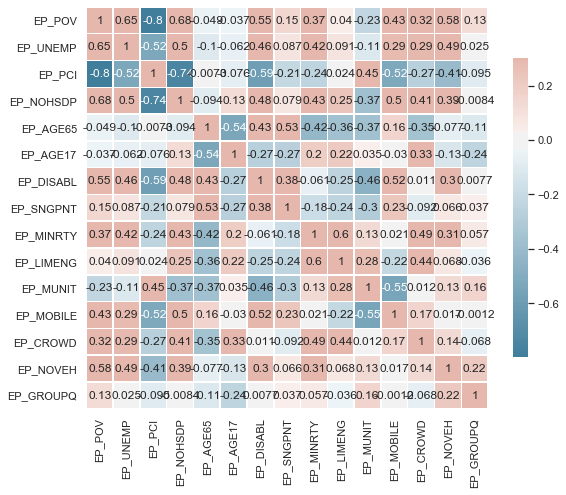

In [143]:
#plt.subplots(figsize=(10, 10))
import seaborn as sns
sns.set(style = "white")
sns.set(style = "whitegrid", color_codes = True)
from scipy import stats
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = stats.spearmanr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix


corr = Ready.corr(method ='spearman')
p_values = corr_sig(Ready)

mask = np.invert(np.tril(p_values < 0.05))

#print (mask)
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 11))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

ax = sns.heatmap(corr, annot=True, cmap=cmap, vmax=.3, center=0, 
                    square=True, linewidths=.5, cbar_kws={"shrink": .5})

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

#sns.heatmap(corr, mask = mask , annot=True, cmap="RdYlGn")
#plt.show()

# SVI calculation 

We calculate the ratio of county value to state value by population for each SVI variables (we use EP-estimate percentage- values in the CDC data set), then we take the average of all 15 SVI variables. 

Let SVI variable set be K, where  

K = { Below Poverty, Unemployed, Income, No High School Diploma, Aged 65 or Older, Aged 17 or Younger, Civilian with a Disability, Single-Parent Households, Minority, Speaks English “Less than Well”, Multi-Unit Structures, Mobile Homes, Crowding, No Vehicle, Group Quarters }

We will use these variables in a county base and state base. While County base values are exactly same as the estimated values for these variables in the CDC website, to calculate the state base, we simply sum the county values for all of the counties in each state for each variable. Then we use the following formula to calculate the SVI value for each county.

Let $S$ is the set of states and $j$ is a county in the state $s$, where $s \in S$, $c^k_j$ SVI variable $k \in K$ value for county j, and $c_s$ SVI variable value for state s.

$SVI_j = \frac{1}{15}\sum_{k \in K} \frac{c^k_j}{c^k_s}$


In [144]:

from collections import Counter
# Sum all SVI variable values for each county
#SVI_county_sum = dict(Counter(E_POV_Prop) + Counter(E_UNEMP_Prop) + Counter(E_PCI_Prop) + Counter(E_NOHSDP_Prop) + Counter(E_AGE65_Prop) + Counter(E_AGE17_Prop) + Counter(E_DISABL_Prop) + Counter(E_SNGPNT_Prop) + Counter(E_MINRTY_Prop) + Counter(E_LIMENG_Prop) + Counter(E_MUNIT_Prop) + Counter(E_MOBILE_Prop) + Counter(E_CROWD_Prop) + Counter(E_NOVEH_Prop) + Counter(E_GROUPQ_Prop))
SVI_county_sum = dict(Counter(E_POV) + Counter(E_UNEMP) + Counter(E_PCI) + Counter(E_NOHSDP) + Counter(E_AGE65) + Counter(E_AGE17) + Counter(E_DISABL) + Counter(E_SNGPNT) + Counter(E_MINRTY) + Counter(E_LIMENG) + Counter(E_MUNIT) + Counter(E_MOBILE) + Counter(E_CROWD) + Counter(E_NOVEH) + Counter(E_GROUPQ))

# Divide the sum of all SVI variable values
SVI_county = {j: (SVI_county_sum[j]/(15*100)) for j in SVI_county_sum }


In [145]:
for i in SVI_county:
    print (i, E_POV[i], E_UNEMP[i], E_PCI[i], E_NOHSDP[i], E_AGE65[i], E_AGE17[i], E_DISABL[i], E_SNGPNT[i], E_MINRTY[i], E_LIMENG[i] , E_MUNIT[i], E_MOBILE[i] , E_CROWD[i], E_NOVEH[i] , E_GROUPQ[i])


1063 38.1 11.5 14.884 20.8 21.3 22.63334935 24.7 11.2843104 82.76069198 0.051639555999999996 5.8489827860000005 35.8 2.168756354 18.0 0.816914945
1005 30.7 9.2 18.473 26.8 18.6 20.925831 21.4 4.751203852 54.18950357 1.8907213059999999 1.731457588 29.3 3.852327448 10.2 11.37967746
1107 22.7 10.3 23.024 18.5 18.5 19.91305637 25.1 7.0053686 46.35182532 1.678307099 1.6478932000000002 25.2 1.309414692 10.3 9.035222052
1131 30.1 15.3 16.841 23.5 19.0 24.12695441 19.2 5.65646082 73.15794401 0.649350649 0.13848018 40.4 1.401141671 15.6 2.349967232
1105 30.8 10.1 15.055 17.2 19.1 21.59690089 22.1 7.328990227999999 70.65533197 0.0 2.280405405 24.3 0.0 13.0 8.716238029
1065 24.2 10.9 21.191 16.0 18.8 23.32365453 21.2 5.150442478 60.46998447 0.209764919 1.398870637 37.4 3.89380531 10.0 1.370788034
1119 31.8 9.7 16.799 13.3 17.5 19.30139877 23.0 5.786236063 75.18949754 0.546267174 3.463329453 32.5 0.422914264 10.9 6.876611706
1123 18.9 9.9 25.217 19.3 21.0 20.88996325 19.8 6.084541807999999 31.1265

5001 17.3 5.8 26.386 16.1 19.0 22.90387406 22.1 4.845814978 30.23891928 0.286191271 1.4258555130000001 15.2 1.5485248969999998 8.0 1.4625432619999998
5037 15.4 6.1 25.38 16.4 18.3 23.65073704 19.9 5.245753795 27.34783642 0.031729915 1.319758673 16.1 2.645423117 6.2 1.3433190680000002
5087 17.4 4.2 24.356 19.4 18.9 23.5395719 18.1 4.3796782930000004 10.66559743 0.953705543 1.556522886 19.4 2.866698519 5.7 0.493492073
5089 18.2 4.8 21.395 13.5 28.1 17.98980335 23.3 6.959598937999999 5.899490168 0.031731929 1.159114858 20.1 1.223827779 6.5 1.0924981790000001
5143 16.4 4.8 27.79 15.0 11.4 24.54959124 10.6 4.557686802 29.10641485 3.809413723 15.729989000000002 4.9 3.86143716 6.0 3.405240885
5013 13.4 4.4 23.688 15.8 21.2 18.644067800000002 22.0 6.432432432000001 27.54237288 0.364741641 0.238989416 30.8 1.1891891890000001 6.2 2.619414484
5099 23.1 5.8 19.912 9.6 20.3 22.75176626 20.9 4.386223138 37.19315052 0.0 1.7151541469999998 23.6 1.1186340890000002 5.0 2.083582804
5009 14.7 4.5 24.727 1

12015 11.1 5.9 32.144 9.4 39.6 12.2694914 22.5 7.865679989 16.08741516 1.98002892 9.140515805 11.8 1.706311532 5.0 1.977168672
12131 13.2 4.8 34.475 10.9 19.5 20.41106326 17.3 6.564551422 15.73056752 0.8329700440000001 18.88799138 13.6 2.8701677610000003 5.5 2.7204008089999996
12053 14.1 6.5 25.86 12.1 27.5 18.47160424 19.6 6.893348197999999 22.45468647 1.143634667 2.948284195 17.0 1.453256888 4.5 1.137870143
12101 12.7 5.7 29.001 10.5 22.5 20.35790942 16.1 6.41387281 25.44633837 1.974552006 6.4259337610000005 19.0 1.557801741 5.5 1.4166930359999999
12111 13.3 5.7 27.121 13.7 23.8 20.03022876 15.1 5.75892507 42.67495774 3.605206922 12.32665857 8.6 2.3553297719999997 4.4 0.95127929
12086 17.1 5.3 28.224 18.6 16.0 20.49556425 10.1 4.354790507 86.81105775 21.58230269 39.08077962 1.2 6.301761885 10.3 1.7028792769999999
12103 12.2 5.4 35.196 8.7 24.3 16.40598922 15.4 6.631153293 26.01408156 2.273057497 24.16544236 9.2 1.8523062430000001 7.7 1.873187196
12071 13.1 5.3 33.543 11.6 28.1 17.838

16035 12.8 6.9 23.412 9.6 26.7 16.08439986 21.2 9.929676512 9.754410239 0.203300646 2.7891891889999996 20.0 1.5471167369999999 4.1 11.10342442
16033 13.3 3.3 18.86 40.2 14.8 29.02519168 5.9 10.68965517 53.88828039 20.21276596 0.0 23.1 5.862068966 1.4 2.628696605
16043 13.0 5.7 23.577 13.4 17.0 26.359446999999996 14.6 6.0501495279999995 15.15360983 2.904019688 0.857174663 11.4 4.370830458 1.5 4.30875576
16063 12.1 3.7 21.656 23.4 13.0 29.60747664 14.1 8.932714617 33.86915888 8.933949006 0.59970015 27.3 5.162412993 1.2 0.878504673
16075 13.4 5.4 25.768 14.3 17.9 26.54772141 17.0 5.509238396000001 21.57781599 3.0406182439999996 2.665538396 13.2 6.061288869 3.3 0.662080825
16027 13.4 5.6 22.232 14.9 13.4 28.85178259 14.6 4.489952889 29.6931072 3.477681811 3.206683542 7.5 4.0531817000000006 3.8 1.526882412
16039 15.3 7.1 23.028 10.1 13.0 25.09441723 14.2 5.025457288 27.36043077 3.17092976 1.529345824 10.5 2.3571563269999998 4.6 2.666118237
16005 16.4 5.5 25.076 7.5 13.8 26.33824987 15.9 5.4

18159 8.5 3.2 31.025 10.7 20.3 20.80200501 14.9 5.693224592000001 5.111462868 0.5432511489999999 0.0 10.0 1.5056461730000001 2.9 1.5631183219999998
18029 9.1 3.7 30.8 10.4 17.0 22.76925564 11.8 5.930047695 3.864265648 0.149161499 5.078544248 3.8 1.441441441 4.2 1.166151297
18147 9.3 2.9 31.287 9.5 19.3 22.13527657 15.1 5.057216685 5.135227662 0.325935123 1.605277625 10.6 1.144333702 3.9 1.432973052
18115 7.1 1.7 30.517 12.4 21.0 19.22029282 14.1 5.440313112 3.5921007830000002 0.0 6.441393875 14.6 0.782778865 4.1 0.902281239
18179 8.4 2.8 28.663 7.8 17.9 24.64745993 12.9 3.829904482 5.647781229 0.231930345 2.9399376630000003 6.1 0.789860397 4.5 2.1098854019999997
18043 9.8 3.8 33.478 9.2 15.7 22.79099845 13.2 4.039192847 12.17796172 0.420364316 6.650614161 2.0 0.572133338 5.4 1.8132436630000002
18171 11.8 4.0 31.104 8.0 20.1 22.01044069 15.7 5.0342567769999995 4.079155032 0.25706940899999997 0.667200427 4.8 1.549002085 2.4 1.0926308120000001
18127 9.9 4.4 34.595 6.4 15.9 22.24020968 10.

20121 6.9 2.8 35.659 4.0 17.0 24.643145699999998 12.5 4.464355278999999 7.30466529 0.307799708 1.960784314 4.8 0.607713284 3.3 2.178531885
20195 6.9 1.4 34.23 6.8 25.3 17.71126761 15.0 3.698332125 4.929577465 0.0 3.2354703419999997 2.9 0.0 0.7 3.0985915489999996
21013 35.5 10.0 15.501 30.4 18.6 21.27206898 30.6 6.024096386 5.755664216 0.051611879000000006 2.138269739 21.7 2.4661144580000003 11.3 3.307080736
21095 36.0 11.2 16.468 27.2 17.9 22.87351586 31.0 5.128435423 4.988950897 0.15987849199999998 2.479947016 19.1 2.739356925 12.0 2.6255665009999998
21115 22.7 8.7 21.974 19.4 17.7 22.49271008 26.7 6.03204524 2.7657506410000003 0.489066541 6.359360301000001 24.9 1.260603205 11.8 2.725987453
21051 36.6 9.2 15.391 35.3 14.8 21.30793401 28.1 5.930202047000001 7.4234092689999995 0.088763576 0.631508974 30.1 3.568617161 13.3 7.074823252000001
21133 33.6 12.6 20.641 24.3 18.5 21.61471182 30.4 6.141343482999999 2.543171115 0.22851702 2.1006973980000003 29.5 3.703322703 7.7 1.085445167
21237 

22061 30.3 4.6 22.863 11.5 13.4 20.12657156 14.7 3.7093495930000002 46.70236634 0.91160159 4.666436225 18.4 2.478545619 9.3 6.823858104
22057 15.6 6.2 28.683 21.8 15.0 23.3630285 17.2 4.236346388 23.16834509 1.130731272 3.215215118 15.8 1.943352758 6.9 2.042646879
22127 18.7 4.9 22.107 18.2 18.3 20.55474045 20.7 4.596024074 35.00314399 0.34706838 0.28700287 23.1 0.9666241109999999 7.5 13.26765877
22123 21.9 10.2 22.439 21.2 18.7 22.85119102 14.8 6.488736532999999 21.22996105 0.08620689699999999 0.174486235 27.7 0.367286974 2.8 3.8311747119999997
22019 17.3 5.6 28.778 13.2 14.6 24.95598133 15.2 4.922859347 32.57728686 0.651982379 5.362212758 16.4 2.549498586 6.5 1.73346758
22011 15.5 8.5 26.331 14.7 15.4 24.79010879 19.9 4.9704142010000005 19.76351807 0.20545170399999999 0.581799785 31.0 2.233727811 7.1 1.136517021
22071 23.7 7.9 31.385 13.5 14.1 20.08596758 14.2 5.402453532999999 69.33157646 1.3713754269999998 15.16568652 0.5 1.418550374 18.6 3.645946603
22051 15.5 5.3 30.374 14.3 16.6

27135 8.1 2.5 30.193 7.1 16.7 24.42549313 11.5 4.8829431439999995 8.07239112 0.41482300899999996 8.400157749 16.1 1.6722408030000002 4.1 1.328038539
27133 9.0 1.7 31.345 6.7 19.8 25.47330355 10.7 5.365355135 6.4773452460000005 0.38764109 6.468244668 1.2 1.916198263 2.9 2.754733036
27035 10.8 2.9 32.368 5.9 22.0 21.75280689 13.7 5.503355705 5.104567326000001 0.1400491 6.272067945 5.6 1.2304250559999999 5.4 1.4746873880000002
27015 6.9 1.6 31.237 6.5 20.8 21.70647379 10.1 6.49386845 6.612883996 0.59310983 7.323727513 2.0 0.520252694 4.6 4.601994993
27049 9.3 3.4 34.803 5.6 19.0 22.40193746 10.4 4.966070327 7.955282619 0.6808178979999999 10.81684129 4.8 1.3469052030000002 5.1 2.1731609219999997
27121 7.2 2.3 34.166 6.0 23.7 20.99022448 13.8 6.9463963060000005 4.045981173 0.20149683399999999 4.733101467 5.0 1.043967075 3.5 1.909847936
27063 7.9 2.7 34.325 7.3 21.6 21.58931083 11.6 6.6530889339999995 7.615029133999999 0.8412309659999999 2.796927319 1.2 1.335143698 3.6 1.175406872
27079 8.5 

29099 9.6 5.3 29.999 10.9 14.5 23.40333376 13.4 5.530292265 5.591848217000001 0.373998557 2.999758173 10.5 1.595139974 3.5 0.97967859
29071 10.5 4.4 30.278 11.6 16.9 23.05530521 13.8 5.231663532 4.976209166 0.20316609100000002 3.98573201 9.6 1.270058374 4.4 0.8886433890000001
29005 12.1 2.5 31.248 8.5 25.4 19.31535666 18.1 6.010928962 3.442340792 0.18105009100000002 0.40595399200000004 2.6 1.0538641690000001 5.8 2.027156244
29189 9.7 4.7 41.426 6.5 17.7 22.10450398 12.0 4.733684086 33.96113425 1.210611177 10.80347424 0.3 1.033045637 6.7 1.8765817480000002
29049 8.9 4.3 29.081 8.0 17.5 24.07804878 13.0 6.787330317 6.27804878 0.17522160399999998 1.299855572 5.3 1.063959887 3.6 2.2682926830000003
29177 11.9 3.6 29.524 11.9 18.0 22.80218579 14.3 3.416779432 6.338797813999999 0.064956155 2.093669379 5.5 1.6350924669999998 6.3 1.219672131
29043 10.0 3.4 28.216 8.0 15.2 25.54227276 13.6 3.807868542 6.663709169 0.520930696 3.744190805 5.4 2.25944067 2.1 0.708632002
29151 7.4 2.0 29.061 10.1 17

35006 26.1 13.7 20.018 17.0 15.6 23.68822283 24.4 8.084519982 80.68870626 1.767867808 2.798982188 28.3 8.658704639 7.4 5.503700123
35053 29.7 4.7 18.948 18.2 18.9 22.79629849 24.2 8.451327434 65.80851821 3.637043034 3.5705610880000003 36.7 2.013274336 8.7 3.0667932139999996
35047 28.2 8.3 20.762 16.7 20.6 19.03886365 28.8 9.940563356 82.17247098 4.299363057 1.5578078080000002 36.2 2.032905504 7.7 5.843968563
35023 25.8 7.6 22.009 17.7 21.2 22.085175699999997 22.2 6.5515187610000005 60.99604375 3.918650794 3.2599837000000003 38.8 2.263251936 6.7 2.653013731
35051 26.7 10.9 25.344 16.0 35.5 15.80092467 26.1 14.34743474 35.30958209 1.784697171 4.313267095 40.0 2.01620162 7.3 2.393255371
35019 15.4 7.0 17.42 17.3 21.8 19.09028256 19.7 16.04046243 80.61107282 3.811163019 2.134831461 27.2 0.794797688 7.9 18.12543074
35017 24.0 7.1 25.59 12.5 26.6 20.15974556 19.9 8.083706016 54.19061043 1.0843833520000001 2.5346692319999997 29.5 2.8858324189999998 7.0 2.826267664
35035 22.1 7.6 23.17 16.6 17

38103 8.6 2.6 35.134 13.0 26.6 21.40342052 16.5 7.565620175 3.722334004 0.0 3.179190751 5.9 0.720535255 3.9 2.439637827
38077 10.9 3.3 31.346 9.3 17.3 21.45318076 11.6 5.63671241 8.73015873 0.254171011 14.30787127 6.1 1.224730707 4.9 7.475083056
38003 11.3 1.9 35.491 7.7 21.9 18.90528676 14.5 6.405202996 7.481785914 0.0 11.82687469 6.2 0.275916437 5.4 5.099943957
38089 8.8 2.5 38.103 9.5 13.0 25.87111097 10.0 3.050143724 12.66046781 0.6653592939999999 19.02624779 6.8 2.9942510380000003 4.9 2.55139796
38029 9.9 1.5 33.088 12.7 29.5 19.09365559 15.6 8.58044164 4.501510574 0.095877277 2.492070684 11.2 0.504731861 2.8 1.63141994
38069 16.7 0.9 30.756 6.7 23.8 21.32816287 9.9 5.870020964 6.519631604 0.02593361 3.791887125 8.2 0.262054507 4.4 3.9263208919999997
38073 6.4 1.3 34.665 9.0 21.4 20.70003764 15.3 8.055672712 5.777192322 0.0 8.578888474 4.7 0.253057782 5.0 2.8603688369999998
38063 11.5 0.4 34.491 8.2 27.3 18.34830684 16.8 6.952965235 4.699378023 0.109170306 1.957753735 5.0 1.840490

41039 17.6 6.9 29.705 8.1 18.8 18.597792899999998 16.9 5.61544724 18.18369315 1.14787401 11.93215711 8.4 2.582199695 8.3 2.102373172
41063 13.6 4.7 30.485 6.9 28.2 18.31810394 18.1 8.089607965 7.0673900629999995 0.79555689 2.680901542 14.7 3.329184816 7.3 1.898914906
41021 10.4 6.9 26.482 10.0 25.3 19.86155485 20.1 5.93824228 12.03407881 0.554323725 2.03539823 16.1 2.019002375 6.2 1.437699681
41013 13.5 6.9 27.007 10.0 24.8 19.8122637 20.0 8.041301627000001 11.79870497 0.366367467 2.927823589 13.9 3.921568627 3.3 0.556255704
41025 10.5 8.7 26.37 8.4 23.9 20.62749415 21.3 5.733662145 12.96270813 0.435729847 2.083333333 23.5 1.849568434 3.2 2.449428925
41071 12.1 4.1 31.314 11.1 16.8 22.46949853 15.4 5.015214084 22.77188999 2.683050162 6.744477719 10.7 4.501738752 5.1 5.283742404
41007 10.0 5.3 29.757 7.9 21.4 19.07830801 18.5 6.1898734179999995 14.48007775 1.553062985 8.30400499 6.3 1.64556962 7.3 2.012684773
41069 14.0 6.8 21.702 8.4 35.8 16.96113074 24.3 7.96875 12.72084806 0.0 1.1340

47181 18.0 7.3 20.689 19.8 18.7 18.27113161 21.0 5.863983345 10.29772959 0.245731208 1.1294053609999999 27.0 2.446217904 6.1 12.41837896
47135 26.9 8.6 27.97 25.1 20.5 22.10499874 21.9 7.712333225 8.138658628 0.0 0.664380626 33.4 2.635860722 4.9 1.984426024
47175 16.8 9.8 20.634 21.0 22.5 18.81944444 26.0 6.305464736 4.288194444 0.201760822 0.14858841 24.9 2.148528725 7.1 1.857638889
47027 26.1 4.2 18.983 19.7 23.7 20.25084923 18.7 5.100361961 5.5918474 1.606701456 2.603686636 29.0 1.711089174 6.4 1.46328717
47095 28.6 8.8 15.732 27.1 15.5 14.33590055 22.4 4.547481052 33.31982165 0.5648122 5.370157269 8.0 0.9808292470000001 11.5 37.80570193
47025 22.4 7.4 21.566 19.9 19.4 18.98083953 22.2 6.3172953839999995 4.809025589 0.425687585 0.7262823420000001 24.8 1.347790076 5.7 3.958149502
47099 17.0 8.1 21.72 16.6 17.6 25.1233003 18.4 5.845864662 6.74809864 1.084238929 1.763417306 12.2 2.362155388 6.1 1.122378428
47073 19.1 6.6 24.695 15.6 20.6 20.24518203 22.9 6.328074346 4.946035223 0.35861

48403 20.1 8.7 24.87 15.3 30.5 18.74701557 26.4 11.43586175 14.46853214 0.070140281 0.22875030100000002 38.2 1.4381813959999998 4.8 0.926368064
48203 17.4 5.4 27.086 14.7 16.5 25.3829979 13.2 5.242143225 36.41333734 1.848909432 1.9656362180000002 21.7 3.9498540269999998 5.4 2.197356564
48355 16.6 5.7 27.74 17.2 14.1 24.765724399999996 13.3 4.827309175 70.52525308 2.4560331509999997 10.85693999 3.3 4.574703942 7.5 2.3399900430000002
48245 17.7 4.9 27.094 15.8 14.2 23.95297633 14.5 4.635006668 59.41299049 4.512068929 9.284562583 3.4 2.40783757 7.3 6.389085476
48017 8.7 2.5 21.945 23.1 13.9 29.02816901 13.0 7.448880234 64.52112676 11.36705812 1.908548708 11.6 4.284323272 5.1 3.0
48401 11.8 7.2 26.658 19.4 16.4 22.60068831 15.3 4.942566821000001 36.25337178 3.122471134 1.307851715 19.4 3.4956925119999998 4.3 9.011254767
48237 16.3 3.9 24.956 18.0 17.1 21.20424763 17.2 4.5138888889999995 22.84229553 3.5586338669999997 0.7681229 18.7 3.914141414 5.6 12.82196114
48365 14.7 4.9 26.577 17.1 18.

51027 28.4 7.2 19.496 29.9 21.4 18.03745181 26.7 4.679659237 5.149623646 0.138596827 1.476811469 32.3 0.723538336 6.7 4.130714155
51135 18.3 4.1 24.571 20.3 19.0 19.39350742 19.7 6.243114212 45.68133221 0.9854239379999999 2.52398524 15.0 2.038193169 6.1 13.63960345
51001 19.0 3.9 26.018 18.5 22.7 21.16120344 14.1 5.521655008 39.97184219 4.858562567 1.673482819 17.7 2.061318649 9.1 3.397300523
51690 23.9 6.0 22.836 17.2 18.7 24.09741674 19.7 4.248011569 56.00684718 0.8639674740000001 10.42875336 1.7 0.0 14.1 3.5247432310000004
51185 17.5 6.5 23.738 18.3 21.5 19.30149268 21.8 5.885911318 6.0620628320000005 0.119262097 1.89361087 22.6 1.203798923 8.0 3.713674495
51520 22.6 6.1 23.015 15.3 20.4 21.310312200000002 22.8 5.563130623999999 11.84957427 0.29419128699999997 9.602383408 1.7 1.295336788 10.7 2.128666036
51111 16.4 4.5 19.848 22.2 21.5 18.181078 21.6 5.497321221 40.59599414 0.332764505 1.5512927440000002 23.6 1.4209177730000002 6.5 7.930304511
51029 15.8 7.0 20.605 20.2 19.3 18.3539

54053 15.9 3.7 24.844 14.0 20.4 21.37956749 17.9 4.114555012 3.385533184 0.0 1.1688311690000002 22.5 0.8791009609999999 8.5 2.777777778
54107 16.8 4.6 27.725 10.1 19.9 21.11581921 19.6 5.286293959 4.844632768 0.198439938 3.829248305 7.9 1.09896303 9.9 1.195856874
54061 20.8 6.4 32.154 7.6 12.2 16.38887309 12.7 4.609030558 12.06932514 0.40025952 16.13541829 10.7 2.5287589319999997 8.5 5.370991902999999
54069 12.6 6.0 32.429 6.5 21.2 19.13485039 15.4 6.473564822999999 7.88743089 0.24768576399999997 8.714763497 4.1 0.38969348 12.5 5.690150203
54095 16.6 5.7 24.924 10.8 21.8 19.69129497 18.1 5.550358591 2.53092725 0.143472023 0.5378486060000001 19.1 0.34299968799999997 5.9 1.032799909
54009 13.2 3.8 26.678 9.4 22.8 17.49855292 18.3 4.181540031 4.416937531 0.339819384 3.112840467 5.8 1.448240694 7.2 4.541609154
54035 17.7 4.0 25.341 11.7 19.9 21.52073892 19.3 3.2821598730000003 3.0615421869999997 0.054838592 0.7458233890000001 19.4 1.4557967180000002 7.9 0.612308437
54031 13.8 3.2 27.004 19

In [146]:
SVI_county

{1063: 0.207099096914,
 1005: 0.17559581481599998,
 1107: 0.16037672488866667,
 1131: 0.19161419931466667,
 1105: 0.1748219110146667,
 1065: 0.1703388735853333,
 1119: 0.1780568366466667,
 1123: 0.137841415424,
 1085: 0.18735402760733333,
 1047: 0.169497026434,
 1121: 0.14319177790666665,
 1087: 0.17872904437133336,
 1059: 0.125768671182,
 1023: 0.15853125943466664,
 1093: 0.12033023037533333,
 1025: 0.15219421757733337,
 1133: 0.12278787863000003,
 1113: 0.14405129364600003,
 1021: 0.13117241429733337,
 1053: 0.13848775682266667,
 1127: 0.1268560676406667,
 1075: 0.12255488052066667,
 1039: 0.12404055332933335,
 1017: 0.13701183775599998,
 1061: 0.12875359690466667,
 1057: 0.12498621399933332,
 1109: 0.14071098335999999,
 1091: 0.160247751888,
 1007: 0.13439262602333332,
 1049: 0.12641562878599996,
 1011: 0.18141923749866665,
 1015: 0.12586876751,
 1111: 0.12944471574866664,
 1045: 0.1275598260766667,
 1101: 0.147415883336,
 1035: 0.14734283098466666,
 1129: 0.14316664768466666,
 1013

In [147]:
# Sum all SVI variable values for each county
#

#SVI_county_sum_no_race = dict(Counter(E_POV_Prop) + Counter(E_UNEMP_Prop) + Counter(E_PCI_Prop) + Counter(E_NOHSDP_Prop) + Counter(E_AGE65_Prop) + Counter(E_AGE17_Prop) + Counter(E_DISABL_Prop) + Counter(E_SNGPNT_Prop) + Counter(E_LIMENG_Prop) + Counter(E_MUNIT_Prop) + Counter(E_MOBILE_Prop) + Counter(E_CROWD_Prop) + Counter(E_NOVEH_Prop) + Counter(E_GROUPQ_Prop))


SVI_county_sum_no_race = dict(Counter(E_POV) + Counter(E_UNEMP) + Counter(E_PCI) + Counter(E_NOHSDP) + Counter(E_AGE65) + Counter(E_AGE17) + Counter(E_DISABL) + Counter(E_SNGPNT) + Counter(E_LIMENG) + Counter(E_MUNIT) + Counter(E_MOBILE) + Counter(E_CROWD) + Counter(E_NOVEH) + Counter(E_GROUPQ))


# Divide the sum of all SVI variable values
SVI_county_no_race = {j: (SVI_county_sum_no_race[j]/(14*100)) for j in SVI_county_sum }


# Proportional Allocation

We consider allocating 1 million CHW over the states proportional to Medicaid enrollment in each state. Further, we allocate CHW to counties in each state proportional to different county vulnerability criterias as follow.

- MEDICAID
- SVI
- YPLL
- UNEMPLOYMENT
- LAST 14 DAYS COVID CASES
- LAST 14 DAYS COVID CASES / POP
- COVID DEATHS / POP

To calculate the total number of allocated CHW to per county according to these vulnerability criterias, we define the following function called "Proportional_allocation", in which we multiply the CHW allocated to each state with the ratio of the chosen vulnerability criteria of the county to the chosen vulnerability criteria of the state, the function return a dictionary with the counties as keys and the number of CHW allocated to each county for the chosen vulnerability criteria as values. 

In [148]:
def Proportional_allocation(county_level, state_level, state_budget):
    prop_allocate = {}
       
    for (j,s) in cartesian_pro_county_state:
        if state_level[s] >= 1e-6 and j in county_level:
            print (j,s, county_level[j],state_level[s], state_budget[s])
            prop_allocate[j,s] = (float(county_level[j])/float(state_level[s]))*float(state_budget[s])
        
        else:
            prop_allocate[j,s] = 0
            
    
    return prop_allocate

In [149]:
def total_state_pop(dict_1):
    state_dict = {}
    for s in State:
        state_dict [s] = sum(float(dict_1[j]*Firstphase_county[j]) for j in dict_1 if (j,s) in cartesian_pro_county_state)  
    return state_dict



In [151]:
def Proportional_allocation_pop(county_level, state_budget):
    prop_allocate = {}
    state_level = total_state_pop(county_level)
       
    for (j,s) in cartesian_pro_county_state:
        if state_level[s] >= 1e-6 and j in county_level:
            #print (j,s, county_level[j], Firstphase_county[j], state_level[s], (county_level[j]/state_level[s]), state_budget[s], ((float(county_level[j])*Firstphase_county[j])/(float(state_level[s])))*float(state_budget[s]) )
        
            prop_allocate[j,s] = ((float(county_level[j])*Firstphase_county[j])/(float(state_level[s])))*float(state_budget[s])
        
        else:
            prop_allocate[j,s] = 0
            
    
    return prop_allocate

In [152]:
# Proportional allocation according to SVI score in each county
Proportional_to_SVI = Proportional_allocation_pop(SVI_county, Vaccine_budget_state)

In [153]:
# Proportional allocation according to YPLL in each county
Proportional_to_SVI_no_race = Proportional_allocation_pop(SVI_county_no_race, Vaccine_budget_state)

In [154]:
#print ('Med', Medicaid_demand[35039])
#print ('Med', Medicaid_demand[4017], 'Pop', population_county[4017], 'Med_capita', 100000*(Medicaid_demand[4017]/population_county[4017]))

In [155]:
# Dictionaries for the different vulnerability criteria values for states

# Dictionary for total Medicaid patient numbers for each state
# Medicaid_demand_state = total_state(Medicaid_demand) 

# Dictionary for total positive COVID cases for last 14 days in each state
#Covid_state = total_state(COVID_14days) 

# Dictionary for total SVI values for each state
SVI_State = total_state(SVI_county) 


# Dictionary for total SVI values for each state
SVI_State_no_race = total_state(SVI_county_no_race) 

# Dictionary for total YPLL values for each state
#YPLL_state = total_state(YPLL) 

 

In [156]:
for j in location:
    print (j , SVI_county[j], SVI_county_no_race[j], E_MINRTY[j])

1063 0.207099096914 0.16277710956500002 82.76069198
1005 0.17559581481599998 0.14943158475285714 54.18950357
1107 0.16037672488866667 0.13872375858071426 46.35182532
1131 0.19161419931466667 0.15304525354428572 73.15794401
1105 0.1748219110146667 0.13684109610857145 70.65533197
1065 0.1703388735853333 0.1393130899342857 60.46998447
1119 0.1780568366466667 0.13706839816428573 75.18949754
1123 0.137841415424 0.12545400659714287 31.126513899999996
1085 0.18735402760733333 0.14691876081500002 75.34477627
1047 0.169497026434 0.12968692197214285 72.68384889
1121 0.14319177790666665 0.12672479182142854 37.37295831
1087 0.17872904437133336 0.13139124756214288 84.14581997
1059 0.125768671182 0.11821502372357143 23.15197356
1023 0.15853125943466664 0.13869714242999998 43.62088975
1093 0.12033023037533333 0.12310639883357143 8.146387196000001
1025 0.15219421757733337 0.1292929708971429 47.28116711
1133 0.12278787863000003 0.1270566154321429 6.30255634
1113 0.14405129364600003 0.11581617858500003 

19171 0.09954228251733334 0.09290101966857142 19.25199624
19045 0.09816729183066669 0.09885087903857143 8.859707092
19105 0.09278564542133334 0.09503554669571429 6.128702757999999
19147 0.09018127492 0.09187041043142857 6.653337776
19135 0.09789866964666667 0.1022198366757143 3.740233124
19117 0.09591016296599997 0.10097163771428568 2.504951649
19141 0.09624966939133332 0.09773458950071429 7.546078786
19087 0.09544334854733334 0.093721253415 11.95526804
19137 0.09201444516200001 0.09411062979214285 6.266786034
19153 0.11157669681866665 0.10362615148428572 22.28843315
19065 0.09227174994666666 0.094328644155 6.3475231029999994
19109 0.09269617176533335 0.09557850996000002 5.234343704
19103 0.11253019348466667 0.10511864379785717 21.62918891
19033 0.09772152493866666 0.09798300580357142 9.406079283
19035 0.09603610360933336 0.09817296286357143 6.612007405
19151 0.09225104119133334 0.09374361487928572 7.1355009560000004
19125 0.09225060837866664 0.09498126155642857 5.402146388999999
19163

28055 0.20870816212533336 0.17863845543428572 62.96840558
28079 0.163190331182 0.13700142413785715 52.98350298
28163 0.18177665228266668 0.14809519913857144 65.33169963
28007 0.15999238465666663 0.13828053037499996 46.39583446
28123 0.166918906116 0.1426509063957143 50.66709022
28063 0.1922252098566667 0.1438003669607143 87.01730104
28151 0.1788610164726667 0.13816269209214288 74.86375578
28099 0.15129853181133338 0.13230145532642862 41.72576026
28021 0.19561938298333337 0.1462188876607143 88.72263175
28001 0.16688942002466667 0.13324485086214286 63.79133883
28103 0.19129962502666661 0.15199993202142856 74.14953271
28069 0.16699382735933335 0.1317387277564286 66.05652218
28051 0.19847651891999998 0.15224297167857143 84.57461803
28053 0.18778359295266667 0.14449830917071427 79.37775659
28091 0.14382054803399996 0.12895195915785712 35.19807923
28135 0.1806343009973333 0.1470461248685714 65.08687668
28143 0.17465395951 0.12926695043928574 81.00720865
28157 0.19242171709999997 0.1546087814

45089 0.1778202483313333 0.14140600060499997 68.76197165
45033 0.16913776016733337 0.1423568026364286 54.40711656
45009 0.16846341522333333 0.13476056751071427 64.03032832
45049 0.163571540832 0.13303481749142856 59.10856676
45025 0.152768689044 0.1353194622971429 39.70578635
45031 0.14964040133866668 0.1279998121342857 45.26086502
45059 0.1418847255346667 0.12906466830857144 32.13655267
45061 0.17089791546666666 0.13484691922142855 67.56118629
45001 0.13884369111733333 0.1265119982042857 31.14873919
45067 0.16538135503533333 0.13331916979500003 61.42519484
45075 0.16115062097333335 0.12500567564285717 66.71798556
45085 0.14959837227333334 0.12111758575 54.83293836
45087 0.13883316176666666 0.12346010043571429 35.40560204
45053 0.15526334235466668 0.12549096463 57.20766305
45081 0.14626839537266664 0.12691054970642854 41.72782347
45047 0.13321477446266666 0.11393084103142856 40.31898425
45037 0.14371907732733333 0.12304923345071428 43.30968916
45071 0.13935775466333333 0.12067798836071

72011 0.23096238571666663 0.17914190628214285 95.64490978
72035 0.23226873194199996 0.17767222372357144 99.6619847
72043 0.2294220157966667 0.17482869736785717 99.37284738
72127 0.24374861511133328 0.19080655472642852 98.49374605
72147 0.21585855137733337 0.16346864164000002 94.93172877
72041 0.23543563581466667 0.1810691624085714 99.65662635
72129 0.2290178315853334 0.17398223054857145 99.95162461
72115 0.22999013049199998 0.17564237619857143 99.08586906
72133 0.22205784213600005 0.16680899766 99.55416648
72021 0.22133250649933334 0.166191615935 99.33049744
72137 0.21431960256866667 0.15900648478785712 98.87032515
72025 0.22359622193 0.16890385614642855 98.92893429
72054 0.2304177302973333 0.17625974224 98.86295631
72003 0.23130294636 0.1811969383857143 93.2787058
72027 0.22966954624400004 0.17538287874 98.96828913
72009 0.2288664471053333 0.17391287469857142 99.82164608
72029 0.22995588793333335 0.17499974192142856 99.93419321
72085 0.2203361304773333 0.16469347439714285 99.93333156


In [157]:
for s in State:
    print (s, SVI_State[s], SVI_State_no_race[s])

Alabama 9.128653540462665 8.097928673622143
Alaska 4.409220932543333 3.6443374272607145
Arizona 2.29297136842 1.923183378464286
Arkansas 9.564243790012664 8.918139728374284
California 8.253603888590668 6.926848028054286
Colorado 7.391158580642668 6.746413409899999
Connecticut 0.9091004893213331 0.8318899603942856
Delaware 0.3747054359966666 0.32575152982499994
District of Columbia 0.19506777341666662 0.16370010909642857
Florida 9.327382839130001 8.43290225861786
Georgia 21.939314047085343 19.195845214493573
Hawaii 0.7482525376346667 0.5382407809014286
Idaho 4.873932562604666 4.667633987263571
Illinois 10.733373305215334 10.53457743836071
Indiana 9.232008323621997 9.252086685849996
Iowa 9.474602586401334 9.501782869930716
Kansas 10.85557287960266 10.445168752252856
Kentucky 14.251261296138004 14.542283450922143
Louisiana 9.005227875452666 7.885200159656427
Maine 1.6037290898266665 1.6496491181385713
Maryland 2.895670873152 2.5419213884285714
Massachusetts 1.618015633624667 1.50894223661

# Vaccine allocation

 <a href="https://covid.cdc.gov/covid-data-tracker/#vaccinations">CDC website</a>  provides the total number of distributed vaccine in each state. 

We allocate the total number of vaccines for each state to its counties proportional to adult population, health care workers + long term care facility residents (phase 1a pop), Phase 1a population weighted by social vulnerability index, and Phase 1a population weighted by social vulnerability index - race.




# Proportional allocation for different vulnerability values

Let V = {Medicaid, SVI, YPLL, Unemployment, COVID, COVID_capita, COVID_death and COVID_death capita, SVI and Medicaid, YPLL and Medicaid, Unemployment and Medicaid, COVID and Medicaid, COVID_capita and Medicaid, COVID_death and Medicaid and COVID_death capita and Medicaid}. We assume $v_j$ represent the vulnerability value for county $j \in J$, while $v_s$ represent the sum of the vulnerability values for each county in the state of county j.

$Prop_{v_j} = \frac{v_j}{v_s}*CHW_s$



In [158]:
Vaccine_budget_state

{'Alabama': 227175,
 'Alaska': 62400,
 'Arizona': 323700,
 'Arkansas': 141375,
 'California': 1806675,
 'Colorado': 259350,
 'Connecticut': 173550,
 'Delaware': 47775,
 'District of Columbia': 37050,
 'Florida': 989625,
 'Georgia': 469950,
 'Hawaii': 70200,
 'Idaho': 77025,
 'Illinois': 471900,
 'Indiana': 307125,
 'Iowa': 147225,
 'Kansas': 136500,
 'Kentucky': 210600,
 'Louisiana': 218400,
 'Maine': 67275,
 'Maryland': 281775,
 'Massachusetts': 330525,
 'Michigan': 468000,
 'Minnesota': 257400,
 'Mississippi': 137475,
 'Missouri': 285675,
 'Montana': 52650,
 'Nebraska': 89700,
 'Nevada': 137475,
 'New Hampshire': 67275,
 'New Jersey': 416325,
 'New Mexico': 99450,
 'New York': 933075,
 'North Carolina': 474825,
 'North Dakota': 37050,
 'Ohio': 545025,
 'Oklahoma': 181350,
 'Oregon': 195975,
 'Pennsylvania': 613275,
 'Rhode Island': 52650,
 'South Carolina': 234975,
 'South Dakota': 43875,
 'Tennessee': 312000,
 'Texas': 1238250,
 'Utah': 129675,
 'Vermont': 35100,
 'Virginia': 394875

In [159]:
# Calling proportional allocation function for different vulnerability criterias



# Proportional allocation according to SVI score in each county
Proportional_to_Adult_pop = Proportional_allocation(Adult_pop_county, Adult_pop_state, Vaccine_budget_state)

# Proportional allocation according to SVI score in each county
Proportional_to_Firstphase = Proportional_allocation(Firstphase_county, Firstphase_State, Vaccine_budget_state)


# Proportional allocation according to SVI score in each county
Proportional_to_ADI = Proportional_allocation_pop(ADI_county, Vaccine_budget_state)

# Proportional allocation according to SVI score in each county
Proportional_to_PVI = Proportional_allocation_pop(PVI_county, Vaccine_budget_state)

# Proportional allocation according to SVI score in each county
Proportional_to_SVI = Proportional_allocation_pop(SVI_county, Vaccine_budget_state)

# Proportional allocation according to YPLL in each county
Proportional_to_SVI_no_race = Proportional_allocation_pop(SVI_county_no_race, Vaccine_budget_state)


1063 Alabama 6440 3779874.0 227175
1005 Alabama 20054 3779874.0 227175
1107 Alabama 16212 3779874.0 227175
1131 Alabama 8104 3779874.0 227175
1105 Alabama 7286 3779874.0 227175
1065 Alabama 11355 3779874.0 227175
1119 Alabama 10327 3779874.0 227175
1123 Alabama 32072 3779874.0 227175
1085 Alabama 7808 3779874.0 227175
1047 Alabama 29720 3779874.0 227175
1121 Alabama 63130 3779874.0 227175
1087 Alabama 15460 3779874.0 227175
1059 Alabama 23582 3779874.0 227175
1023 Alabama 10322 3779874.0 227175
1093 Alabama 23592 3779874.0 227175
1025 Alabama 18841 3779874.0 227175
1133 Alabama 18858 3779874.0 227175
1113 Alabama 43783 3779874.0 227175
1021 Alabama 33420 3779874.0 227175
1053 Alabama 28769 3779874.0 227175
1127 Alabama 49854 3779874.0 227175
1075 Alabama 10835 3779874.0 227175
1039 Alabama 29037 3779874.0 227175
1017 Alabama 26595 3779874.0 227175
1061 Alabama 20599 3779874.0 227175
1057 Alabama 13014 3779874.0 227175
1109 Alabama 26863 3779874.0 227175
1091 Alabama 14918 3779874.0 227

13025 Georgia 14298 7898607.0 469950
13083 Georgia 13107 7898607.0 469950
13179 Georgia 44067 7898607.0 469950
13289 Georgia 6632 7898607.0 469950
13307 Georgia 1977 7898607.0 469950
13175 Georgia 35686 7898607.0 469950
13173 Georgia 7763 7898607.0 469950
13185 Georgia 87682 7898607.0 469950
13183 Georgia 13419 7898607.0 469950
13033 Georgia 16642 7898607.0 469950
13147 Georgia 20444 7898607.0 469950
13149 Georgia 9070 7898607.0 469950
13271 Georgia 13351 7898607.0 469950
13119 Georgia 17786 7898607.0 469950
13213 Georgia 29813 7898607.0 469950
13249 Georgia 3979 7898607.0 469950
13031 Georgia 60904 7898607.0 469950
13023 Georgia 10081 7898607.0 469950
13123 Georgia 24472 7898607.0 469950
13241 Georgia 13890 7898607.0 469950
13229 Georgia 14432 7898607.0 469950
13265 Georgia 1370 7898607.0 469950
13045 Georgia 89171 7898607.0 469950
13125 Georgia 2313 7898607.0 469950
13101 Georgia 3100 7898607.0 469950
13255 Georgia 49761 7898607.0 469950
13195 Georgia 22487 7898607.0 469950
13127 Geo

21051 Kentucky 16028 3439746.0 210600
21133 Kentucky 17476 3439746.0 210600
21237 Kentucky 5539 3439746.0 210600
21129 Kentucky 5475 3439746.0 210600
21159 Kentucky 9325 3439746.0 210600
21153 Kentucky 9635 3439746.0 210600
21147 Kentucky 13510 3439746.0 210600
21131 Kentucky 8075 3439746.0 210600
21053 Kentucky 7864 3439746.0 210600
21099 Kentucky 14058 3439746.0 210600
21025 Kentucky 10335 3439746.0 210600
21075 Kentucky 4788 3439746.0 210600
21193 Kentucky 20682 3439746.0 210600
21171 Kentucky 8230 3439746.0 210600
21119 Kentucky 12194 3439746.0 210600
21203 Kentucky 13110 3439746.0 210600
21175 Kentucky 10812 3439746.0 210600
21071 Kentucky 28582 3439746.0 210600
21121 Kentucky 24036 3439746.0 210600
21041 Kentucky 7920 3439746.0 210600
21233 Kentucky 10040 3439746.0 210600
21065 Kentucky 11148 3439746.0 210600
21155 Kentucky 14559 3439746.0 210600
21031 Kentucky 9873 3439746.0 210600
21181 Kentucky 5454 3439746.0 210600
21043 Kentucky 21108 3439746.0 210600
21201 Kentucky 1616 343

29127 Missouri 21784 4723298.0 285675
29117 Missouri 11808 4723298.0 285675
29145 Missouri 44203 4723298.0 285675
29077 Missouri 229251 4723298.0 285675
29197 Missouri 3358 4723298.0 285675
29129 Missouri 2756 4723298.0 285675
29013 Missouri 12440 4723298.0 285675
29029 Missouri 37257 4723298.0 285675
29199 Missouri 3488 4723298.0 285675
29053 Missouri 13828 4723298.0 285675
29095 Missouri 531172 4723298.0 285675
29107 Missouri 25090 4723298.0 285675
29041 Missouri 5776 4723298.0 285675
29089 Missouri 7842 4723298.0 285675
29031 Missouri 61681 4723298.0 285675
29147 Missouri 18788 4723298.0 285675
29101 Missouri 42130 4723298.0 285675
29219 Missouri 26240 4723298.0 285675
29113 Missouri 42058 4723298.0 285675
29019 Missouri 141592 4723298.0 285675
29227 Missouri 1617 4723298.0 285675
29027 Missouri 35375 4723298.0 285675
29115 Missouri 9237 4723298.0 285675
29073 Missouri 11668 4723298.0 285675
29087 Missouri 3529 4723298.0 285675
29173 Missouri 8052 4723298.0 285675
29186 Missouri 139

39103 Ohio 137718 9050387.0 545025
39041 Ohio 147438 9050387.0 545025
40023 Oklahoma 11212 2975906.0 181350
40115 Oklahoma 23605 2975906.0 181350
40133 Oklahoma 18615 2975906.0 181350
40101 Oklahoma 51910 2975906.0 181350
40015 Oklahoma 21877 2975906.0 181350
40089 Oklahoma 24610 2975906.0 181350
40077 Oklahoma 8110 2975906.0 181350
40107 Oklahoma 9286 2975906.0 181350
40021 Oklahoma 37825 2975906.0 181350
40127 Oklahoma 8659 2975906.0 181350
40079 Oklahoma 37850 2975906.0 181350
40095 Oklahoma 12652 2975906.0 181350
40069 Oklahoma 8447 2975906.0 181350
40135 Oklahoma 31823 2975906.0 181350
40141 Oklahoma 5656 2975906.0 181350
40111 Oklahoma 29529 2975906.0 181350
40067 Oklahoma 4658 2975906.0 181350
40005 Oklahoma 10720 2975906.0 181350
40063 Oklahoma 10419 2975906.0 181350
40091 Oklahoma 15751 2975906.0 181350
40001 Oklahoma 16220 2975906.0 181350
40055 Oklahoma 4670 2975906.0 181350
40071 Oklahoma 33310 2975906.0 181350
40029 Oklahoma 4207 2975906.0 181350
40035 Oklahoma 11216 29759

46071 South Dakota 2251 656530.0 43875
46017 South Dakota 1259 656530.0 43875
46121 South Dakota 5934 656530.0 43875
46137 South Dakota 1945 656530.0 43875
46095 South Dakota 1400 656530.0 43875
46007 South Dakota 2199 656530.0 43875
46041 South Dakota 3676 656530.0 43875
46031 South Dakota 2638 656530.0 43875
46005 South Dakota 13392 656530.0 43875
46023 South Dakota 6568 656530.0 43875
46085 South Dakota 2716 656530.0 43875
46109 South Dakota 7493 656530.0 43875
46047 South Dakota 5589 656530.0 43875
46019 South Dakota 7700 656530.0 43875
46065 South Dakota 13506 656530.0 43875
46015 South Dakota 3931 656530.0 43875
46129 South Dakota 4199 656530.0 43875
46067 South Dakota 5492 656530.0 43875
46135 South Dakota 17905 656530.0 43875
46053 South Dakota 3202 656530.0 43875
46103 South Dakota 84919 656530.0 43875
46079 South Dakota 10102 656530.0 43875
46101 South Dakota 4838 656530.0 43875
46009 South Dakota 5591 656530.0 43875
46081 South Dakota 20973 656530.0 43875
46033 South Dakota 

51790 Virginia 19802 6588764.0 394875
51630 Virginia 22617 6588764.0 394875
51191 Virginia 44165 6588764.0 394875
51021 Virginia 5354 6588764.0 394875
51650 Virginia 106529 6588764.0 394875
51193 Virginia 14406 6588764.0 394875
51017 Virginia 3583 6588764.0 394875
51035 Virginia 24175 6588764.0 394875
51530 Virginia 5140 6588764.0 394875
51171 Virginia 34044 6588764.0 394875
51053 Virginia 22649 6588764.0 394875
51175 Virginia 14417 6588764.0 394875
51750 Virginia 15821 6588764.0 394875
51067 Virginia 45390 6588764.0 394875
51775 Virginia 20473 6588764.0 394875
51830 Virginia 13371 6588764.0 394875
51137 Virginia 28061 6588764.0 394875
51119 Virginia 8949 6588764.0 394875
51036 Virginia 5928 6588764.0 394875
51678 Virginia 6592 6588764.0 394875
51047 Virginia 38460 6588764.0 394875
51109 Virginia 28691 6588764.0 394875
51031 Virginia 44210 6588764.0 394875
51580 Virginia 4451 6588764.0 394875
51181 Virginia 5392 6588764.0 394875
51187 Virginia 30749 6588764.0 394875
51540 Virginia 3972

8063 Colorado 131 267471.0 259350
8125 Colorado 348 267471.0 259350
8103 Colorado 43 267471.0 259350
8061 Colorado 0 267471.0 259350
8015 Colorado 359 267471.0 259350
8001 Colorado 22831 267471.0 259350
8121 Colorado 56 267471.0 259350
8031 Colorado 46928 267471.0 259350
8123 Colorado 6382 267471.0 259350
8095 Colorado 48 267471.0 259350
8033 Colorado 0 267471.0 259350
8045 Colorado 1518 267471.0 259350
8065 Colorado 26 267471.0 259350
8041 Colorado 35606 267471.0 259350
8017 Colorado 23 267471.0 259350
8027 Colorado 0 267471.0 259350
8051 Colorado 216 267471.0 259350
8007 Colorado 167 267471.0 259350
8057 Colorado 0 267471.0 259350
8005 Colorado 32728 267471.0 259350
8013 Colorado 19717 267471.0 259350
8067 Colorado 1517 267471.0 259350
8049 Colorado 96 267471.0 259350
8111 Colorado 0 267471.0 259350
8097 Colorado 206 267471.0 259350
8069 Colorado 18110 267471.0 259350
8037 Colorado 1275 267471.0 259350
8053 Colorado 0 267471.0 259350
8107 Colorado 760 267471.0 259350
8113 Colorado 10

19061 Iowa 8149 172333.0 147225
19167 Iowa 1927 172333.0 147225
19003 Iowa 169 172333.0 147225
19025 Iowa 542 172333.0 147225
19089 Iowa 406 172333.0 147225
19133 Iowa 531 172333.0 147225
19169 Iowa 3482 172333.0 147225
19083 Iowa 915 172333.0 147225
19183 Iowa 1000 172333.0 147225
19159 Iowa 282 172333.0 147225
19077 Iowa 270 172333.0 147225
19107 Iowa 272 172333.0 147225
19079 Iowa 555 172333.0 147225
19113 Iowa 10139 172333.0 147225
19129 Iowa 654 172333.0 147225
19097 Iowa 592 172333.0 147225
19069 Iowa 390 172333.0 147225
19131 Iowa 526 172333.0 147225
19081 Iowa 498 172333.0 147225
19019 Iowa 475 172333.0 147225
19001 Iowa 348 172333.0 147225
19085 Iowa 869 172333.0 147225
19027 Iowa 1368 172333.0 147225
19071 Iowa 277 172333.0 147225
19165 Iowa 623 172333.0 147225
19015 Iowa 1263 172333.0 147225
19055 Iowa 555 172333.0 147225
19119 Iowa 396 172333.0 147225
19161 Iowa 379 172333.0 147225
19037 Iowa 396 172333.0 147225
19149 Iowa 959 172333.0 147225
19023 Iowa 578 172333.0 147225


29131 Missouri 674 348484.0 285675
29211 Missouri 216 348484.0 285675
29135 Missouri 371 348484.0 285675
29105 Missouri 975 348484.0 285675
29123 Missouri 404 348484.0 285675
29045 Missouri 130 348484.0 285675
29217 Missouri 585 348484.0 285675
29175 Missouri 1107 348484.0 285675
29001 Missouri 1344 348484.0 285675
29137 Missouri 160 348484.0 285675
29075 Missouri 499 348484.0 285675
29007 Missouri 674 348484.0 285675
29169 Missouri 819 348484.0 285675
29063 Missouri 400 348484.0 285675
29209 Missouri 465 348484.0 285675
29035 Missouri 136 348484.0 285675
29205 Missouri 112 348484.0 285675
29127 Missouri 2377 348484.0 285675
29117 Missouri 653 348484.0 285675
29145 Missouri 2071 348484.0 285675
29077 Missouri 29713 348484.0 285675
29197 Missouri 37 348484.0 285675
29129 Missouri 114 348484.0 285675
29013 Missouri 588 348484.0 285675
29029 Missouri 1312 348484.0 285675
29199 Missouri 40 348484.0 285675
29053 Missouri 682 348484.0 285675
29095 Missouri 51242 348484.0 285675
29107 Missour

40007 Oklahoma 54 177494.0 181350
40093 Oklahoma 81 177494.0 181350
40129 Oklahoma 0 177494.0 181350
40145 Oklahoma 698 177494.0 181350
40103 Oklahoma 102 177494.0 181350
40003 Oklahoma 89 177494.0 181350
40151 Oklahoma 138 177494.0 181350
40073 Oklahoma 444 177494.0 181350
40083 Oklahoma 796 177494.0 181350
40027 Oklahoma 11904 177494.0 181350
40051 Oklahoma 1339 177494.0 181350
40131 Oklahoma 1890 177494.0 181350
40017 Oklahoma 2263 177494.0 181350
40043 Oklahoma 69 177494.0 181350
40053 Oklahoma 72 177494.0 181350
40087 Oklahoma 690 177494.0 181350
41045 Oregon 709 214384.0 195975
41037 Oregon 60 214384.0 195975
41059 Oregon 3094 214384.0 195975
41031 Oregon 373 214384.0 195975
41035 Oregon 1900 214384.0 195975
41065 Oregon 1301 214384.0 195975
41011 Oregon 3843 214384.0 195975
41019 Oregon 6145 214384.0 195975
41057 Oregon 366 214384.0 195975
41001 Oregon 470 214384.0 195975
41033 Oregon 4039 214384.0 195975
41047 Oregon 18863 214384.0 195975
41023 Oregon 163 214384.0 195975
41029 

48443 Texas 0 1329899.0 1238250
48381 Texas 2889 1329899.0 1238250
48157 Texas 23545 1329899.0 1238250
48173 Texas 0 1329899.0 1238250
48393 Texas 0 1329899.0 1238250
48121 Texas 26819 1329899.0 1238250
48491 Texas 20226 1329899.0 1238250
48085 Texas 43741 1329899.0 1238250
48065 Texas 0 1329899.0 1238250
48397 Texas 4857 1329899.0 1238250
49037 Utah 579 126856.0 129675
49007 Utah 684 126856.0 129675
49031 Utah 0 126856.0 129675
49039 Utah 443 126856.0 129675
49047 Utah 457 126856.0 129675
49019 Utah 147 126856.0 129675
49055 Utah 0 126856.0 129675
49033 Utah 0 126856.0 129675
49017 Utah 57 126856.0 129675
49027 Utah 148 126856.0 129675
49013 Utah 386 126856.0 129675
49053 Utah 6666 126856.0 129675
49041 Utah 617 126856.0 129675
49001 Utah 62 126856.0 129675
49021 Utah 1747 126856.0 129675
49005 Utah 3935 126856.0 129675
49025 Utah 34 126856.0 129675
49057 Utah 10747 126856.0 129675
49015 Utah 120 126856.0 129675
49023 Utah 274 126856.0 129675
49049 Utah 23973 126856.0 129675
49035 Uta

54091 West Virginia 451 100486.0 89700
54093 West Virginia 116 100486.0 89700
54039 West Virginia 18269 100486.0 89700
54049 West Virginia 2096 100486.0 89700
54071 West Virginia 154 100486.0 89700
54103 West Virginia 432 100486.0 89700
54085 West Virginia 123 100486.0 89700
54105 West Virginia 24 100486.0 89700
54057 West Virginia 905 100486.0 89700
54029 West Virginia 1191 100486.0 89700
54073 West Virginia 304 100486.0 89700
54033 West Virginia 7214 100486.0 89700
54017 West Virginia 0 100486.0 89700
54053 West Virginia 452 100486.0 89700
54107 West Virginia 4128 100486.0 89700
54061 West Virginia 14587 100486.0 89700
54069 West Virginia 6334 100486.0 89700
54095 West Virginia 321 100486.0 89700
54009 West Virginia 863 100486.0 89700
54035 West Virginia 691 100486.0 89700
54031 West Virginia 412 100486.0 89700
54003 West Virginia 2373 100486.0 89700
54051 West Virginia 1005 100486.0 89700
54065 West Virginia 235 100486.0 89700
54037 West Virginia 920 100486.0 89700
54079 West Virgin

In [160]:
for j in SVI_county:
    print(j, SVI_county[j], SVI_county_no_race[j])

1063 0.207099096914 0.16277710956500002
1005 0.17559581481599998 0.14943158475285714
1107 0.16037672488866667 0.13872375858071426
1131 0.19161419931466667 0.15304525354428572
1105 0.1748219110146667 0.13684109610857145
1065 0.1703388735853333 0.1393130899342857
1119 0.1780568366466667 0.13706839816428573
1123 0.137841415424 0.12545400659714287
1085 0.18735402760733333 0.14691876081500002
1047 0.169497026434 0.12968692197214285
1121 0.14319177790666665 0.12672479182142854
1087 0.17872904437133336 0.13139124756214288
1059 0.125768671182 0.11821502372357143
1023 0.15853125943466664 0.13869714242999998
1093 0.12033023037533333 0.12310639883357143
1025 0.15219421757733337 0.1292929708971429
1133 0.12278787863000003 0.1270566154321429
1113 0.14405129364600003 0.11581617858500003
1021 0.13117241429733337 0.12635019646857146
1053 0.13848775682266667 0.11997562070285714
1127 0.1268560676406667 0.12802230256500002
1075 0.12255488052066667 0.1213031418292857
1039 0.12404055332933335 0.12096510898

18171 0.08839583682133334 0.091796143
18127 0.09571530919466667 0.09055162904428571
18081 0.09072342546466668 0.08934455704785714
18183 0.08730803938466666 0.09027678312357143
18173 0.09144063173066665 0.09253926755071429
18063 0.08865975589666668 0.08374230888214287
18129 0.08635826892733334 0.08962597894785715
18059 0.08388042037533333 0.084427593335
18011 0.09453983884066666 0.09458290609
18057 0.09537407518533335 0.09052200369857144
19047 0.13853327232866666 0.1240151479092857
19179 0.11017868163533334 0.10534466408785711
19053 0.10600164376866666 0.10834518051357145
19007 0.10484217491466667 0.10887764117357145
19021 0.13255659761466668 0.11314439384428573
19127 0.11989934742200001 0.10767880879499998
19185 0.10180354794133334 0.10627541659142857
19039 0.10730202423466667 0.10257329214428572
19175 0.10024741097866667 0.10312500042285713
19193 0.11655123756466666 0.1055643062192857
19057 0.10771019041533335 0.10635596295214286
19177 0.09836001422866666 0.10276834691357144
19111 0.1

27025 0.08585805833133332 0.08727105467285713
27163 0.09661599200066669 0.09115616070071428
27055 0.08337663846133334 0.08647083299
27171 0.08553838354799999 0.08618690830999999
27039 0.08382606049533332 0.08421173415571427
27019 0.08976357776800001 0.08819858448
28055 0.20870816212533336 0.17863845543428572
28079 0.163190331182 0.13700142413785715
28163 0.18177665228266668 0.14809519913857144
28007 0.15999238465666663 0.13828053037499996
28123 0.166918906116 0.1426509063957143
28063 0.1922252098566667 0.1438003669607143
28151 0.1788610164726667 0.13816269209214288
28099 0.15129853181133338 0.13230145532642862
28021 0.19561938298333337 0.1462188876607143
28001 0.16688942002466667 0.13324485086214286
28103 0.19129962502666661 0.15199993202142856
28069 0.16699382735933335 0.1317387277564286
28051 0.19847651891999998 0.15224297167857143
28053 0.18778359295266667 0.14449830917071427
28091 0.14382054803399996 0.12895195915785712
28135 0.1806343009973333 0.1470461248685714
28143 0.1746539595

39057 0.10170039750199998 0.09740328892357143
39045 0.09390878081133333 0.09063642694785715
39063 0.09605782037933334 0.09507520251357143
39173 0.099346444504 0.09807535057571429
39109 0.09053633747066665 0.09149682430571428
39037 0.08709787038866669 0.09052096275285718
39055 0.09514169587266667 0.09876125358785715
39085 0.09678080265333332 0.09528551375000002
39135 0.08751748569266668 0.09117531417142857
39051 0.09061003480599997 0.08922474990642856
39175 0.08489600077333333 0.08737233849071428
39025 0.09649698347466666 0.09876071104785715
39069 0.08932545588866667 0.088423323645
39011 0.08428584680666668 0.08719320395214286
39107 0.08272276606399999 0.08532950982642856
39165 0.09133049288933331 0.08797270863857143
39159 0.08757085887466667 0.08634636995142857
39137 0.08470278389266667 0.08504686968142858
39103 0.084819111638 0.08647062364142857
39041 0.09272634663533331 0.08866706652357143
40023 0.146837818348 0.12920247008714286
40115 0.13174647995266667 0.11616579927785714
40133 0.

50019 0.10034972884133331 0.10399672033785712
50021 0.09924438230133333 0.10297360596785714
50009 0.09975250674933335 0.10355971345285714
50025 0.100811732486 0.10307530383142857
50003 0.102553186544 0.10567614576857143
50005 0.09854285531599999 0.10189609218214285
50017 0.0940294238433333 0.0975805974792857
50023 0.095941529444 0.09864098867142855
50027 0.09556883126599999 0.09857143790571428
50007 0.103489032734 0.10267529229357142
50011 0.090535136564 0.09262890258642857
50015 0.09463158338133336 0.09747789946357145
50001 0.09295621844600002 0.09427201951214288
50013 0.08984428630466668 0.09112481869714285
51640 0.14597254781666666 0.14146020749642857
51595 0.1824289608666667 0.14150097227142858
51105 0.133838804808 0.13832522687
51720 0.13422033229866667 0.13565708507000002
51590 0.1559587379106667 0.12594765120428575
51730 0.18217126371533335 0.134518633995
51025 0.16784131308866668 0.13750465835214284
51195 0.13731974465066665 0.14103146114214285
51089 0.13639967090266666 0.12459

# Normalize values for comparison
To be able compare the different vulnerability values for each county, we normalize all vulnerability values as follows. 

Let $m_{v_s} = \min \{v_j, \text{ for county j in state s }\}$  and 
$M_{v_s} = \max \{v_j, \text{ for county j in state s }\}$.

We calculate the normalize value for each vulnerability for each county by substracting the min vulnerability in the state of the county and dividing that by the differences between max and min value of the vulnerability values in the state. Mathematical formulation for the normalization is as follows.

$N_{v_j} = \frac{v_j - m_{v_s}}{M_{v_s} - m_{v_s}}$ 

for each $v \in V$, where V = {Medicaid, SVI, YPLL, Unemployment, COVID, COVID_capita, COVID_death and COVID_death capita, SVI and Medicaid, YPLL and Medicaid, Unemployment and Medicaid, COVID and Medicaid, COVID_capita and Medicaid, COVID_death and Medicaid and COVID_death capita and Medicaid}, j is a county in each state $s \in S$.


In [161]:
#Normalize function to normalize the vulnerability values to be able to compare them

def normalize(dict_1):
    
    result = {}
    min_data = {s: min(dict_1[j] for j in location if (j,s) in cartesian_pro_county_state) for s in State }
    max_data = {s: max(dict_1[j] for j in location if (j,s) in cartesian_pro_county_state) for s in State }
    
    for (j,s) in cartesian_pro_county_state:
        
        if (max_data[s] - min_data[s]) != 0 :
    
            result[j] = (dict_1[j] - min_data[s])/(max_data[s] - min_data[s])
        
        else:
            result[j] = 1
    
    return result 

# Percentile Rank

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.percentileofscore.html"> The function scipy.stats.percentileofscore (a, score, kind='rank')   </a>
computes the percentile rank of a score relative to a list of scores. 
"rank": Average percentage ranking of score. In case of multiple matches, average the percentage rankings of all matching scores.

In [162]:
from scipy import stats

# Calculate percentile ranks

def percentile_ranks(data):
    x = {s: [] for s in State}

    for (j,s) in cartesian_pro_county_state:
         
        x[s].append(data[j])
    
    
    
    percentile_ranks = {i: stats.percentileofscore(x[s], data[i], 'rank') for (i,s) in cartesian_pro_county_state}

    return percentile_ranks

In [163]:
# Write timestamp 

time_stamp = time.strftime('%m-%d-%Y %H:%M:%S')
with open('Output/time_stamp.csv','w') as f:
    w = csv.writer(f)
    now = time.strftime('%m/%d/%Y %H:%M:%S')
    w.writerow(['time',now])
    

In [164]:
#print (Medicaid_demand)

In [165]:
#Write a function to order the dicts
def order_k(dict_1):
    dict_2 = {}
    for m in location:
        if m in dict_1.keys():
            dict_2[m] = dict_1[m]
        else:
            dict_2[m] = 0
    
    return dict_2
            

In [166]:
Adult_pop_county = order_k(Adult_pop_county)
ADI_county = order_k(ADI_county)#{m: SVI_county[m] for m in location}
PVI_county = order_k(PVI_county)#{m: SVI_county[m] for m in location}

SVI_county = order_k(SVI_county)#{m: SVI_county[m] for m in location}
SVI_county_no_race = order_k(SVI_county_no_race)#{m: SVI_county[m] for m in location}
Firstphase_county = order_k(Firstphase_county)



In [167]:
# Write file allocation with each strategies for each county 

Strategies = ["Adult_pop", "Firstphase", "ADI", "PVI" , "SVI", "SVI_no_race"]

fieldnames = []  
fieldnames.append('County_FIPS')


SVI_values = {i:SVI_county[i] for i in location}
s_count = 1
for s in Strategies:   
    fieldnames.append('Proportional_allocation_to_' + s)
    fieldnames.append(s)
    fieldnames.append('Percentile_ranks_' + s)

    
        

writefile = 'Output/County_level_proportional_vaccine_allocation.csv'
with open( writefile, 'w' ) as f:
    writer = csv.writer(f)                
    writer.writerow(fieldnames)
    for row in zip(location
                   , Proportional_to_Adult_pop.values(),        Adult_pop_county.values(),            percentile_ranks(Adult_pop_county).values()
                   , Proportional_to_Firstphase.values(),       Firstphase_county.values(),    percentile_ranks(Firstphase_county).values()
                   , Proportional_to_ADI.values(),              ADI_county.values(),           percentile_ranks(ADI_county).values()
                   , Proportional_to_PVI.values(),              PVI_county.values(),           percentile_ranks(PVI_county).values()
                   , Proportional_to_SVI.values(),              SVI_county.values(),           percentile_ranks(SVI_county).values()
                   , Proportional_to_SVI_no_race.values(),      SVI_county_no_race.values(),   percentile_ranks(SVI_county_no_race).values()
                    ):                    
       
        writer.writerow(row)

In [168]:
Vaccine_state = {s: Vaccine_budget_state[s] for s in State}

In [169]:
writefile = 'Output/State_level_vaccine_allocation.csv'

cl = ['State', 'Vaccine_allocation']
with open( writefile, 'w' ) as f:
    writer = csv.writer(f)                
    writer.writerow(cl)
    for row in zip( State, Vaccine_state.values()):
        writer.writerow(row)